In [5]:
%load_ext autoreload
%autoreload 2
import cv2
from scipy.ndimage import distance_transform_edt as dist
import IPython.display 
import importlib
import skimage.io as imgio
import numpy as np
import os
import torch
import torch.nn.functional as F
import math
import re
from matplotlib import pyplot as plt
from scipy import ndimage
from topoloss4neurons.networks import UNet
import networktraining as nt
# from topoloss4neurons import load_dataset
%matplotlib inline
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
    
def showCube(vol):
    v1=np.max(vol,axis=0)
    v2=np.max(vol,axis=1)
    v3=np.max(vol,axis=2)
    imshow(v1*255)
    imshow(v2*255)
    imshow(v3*255) 

path_apls: /cvlabdata1/home/zakariya/SegmentingBrains


In [6]:
from tqdm import tqdm 

In [7]:
def volInds(swcCoords,scale,volDims,offset,downsampling):
    """
    For scaling and shifting coordinates
    """
    x=int((swcCoords[volDims[0]]*scale[0]+offset[0])*downsampling[0])
    y=int((swcCoords[volDims[1]]*scale[1]+offset[1])*downsampling[1])
    z=int((swcCoords[volDims[2]]*scale[2]+offset[2])*downsampling[2])
    return x,y,z

In [8]:
def traceLine(lbl,begPoint,endPoint):
    """
    Renders a line represented by two nodes
    """
    d=endPoint-begPoint
    s=begPoint
    mi=np.argmax(np.fabs(d))
    coef=d/d[mi]
    sz=np.array(lbl.shape)
    numsteps=int(abs(d[mi]))+1
    step=int(d[mi]/abs(d[mi]))
    for t in range(0,numsteps):
        pos=np.array(s+coef*t*step)
        if np.all(pos<sz) and np.all(pos>=0):
            #print(pos)
            lbl[tuple(pos.astype(np.int))]=1
#         else:
#             print("reqested point",pos,"but the volume size is",sz)
    return lbl


In [9]:
def readSWC(brain_i):
    """
    Returns the full annotation information for the given brain index
    """
    if brain_i == 6:
        swcfname = "/cvlabdata2/home/oner/CarlsData/AL066-AL_stamp_2019_07_23_10_34.ano.eswc"
    elif brain_i == 8:
        swcfname = "/cvlabdata2/home/oner/CarlsData/AL080_stamp_2020_01_22_13_26.ano.eswc"
    elif brain_i == 9:
        swcfname = "/cvlabdata2/home/oner/CarlsData /AL092_stamp_2020_01_09_11_10.ano.eswc_sorted.eswc"
    elif brain_i == 175:
        swcfname = "/cvlabdata2/home/oner/CarlsData/annotations/AL175_stamp_2021_02_10_13_52.ano.eswc"
    elif brain_i == 223:
        swcfname = None
        return {0:[6833,7549,488],1:[3091,7665,410],2:[7088,7804,554],3:[3346,7920,665]}
    elif brain_i == 230:
        swcfname = None
        return {0:[3935,8628,288],1:[4109,8883,543],2:[3713,8397,389],3:[3968,8653,644]}
    elif brain_i == 225:
        swcfname = None
        return {0:[3600,8400,600]}
    elif brain_i == 250:
        swcfname = None
        return {0:[3500,8700,400]}
    elif brain_i == 177:
        swcfname = None
        return {0:[2100,8200,1000]}
    else:
        return
    nodes=dict()
    for a in open(swcfname):
        if (re.match('\s*\#',a)!=None):
#             print("commment line", a)
            continue
        b=a.split()
        c=map(lambda x: float(x), b)
        d=list(c)
        nodes[int(d[0])]=d
    return nodes

def getCoords(brain_i):
    """
    Returns the location of nodes in the annotations
    """
    nodes = readSWC(brain_i)
    coords = []
    for k in nodes :
        n=nodes[k]
        if brain_i == 6:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 8:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 9:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 175:
            x,y,z= volInds(n,[1,1,1],[2,3,4], [0,0,0], [1,1,1])
        elif brain_i == 223:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 230:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 225:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 250:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        elif brain_i == 177:
            x,y,z= volInds(n,[1,1,1],[0,1,2], [0,0,0], [1,1,1])
        coords.append([x,y,z])
    return coords

def renderSWC2volume(swcfname, volumeDims, volCL, scale, offset, downsampling):
    '''
      swcfname      name of the swc file
      volumeDims    one-dimensional array;
                    volumeDims[1] is index of volCL dimension corresponding to X
                    volumeDims[2] is index of volCL dimension corresp to Y
                    volumeDims[3] is index of volCL dimension corresp to Z
                    X,Y,Z are as interpreted in the CWS format
      volCL         np array into which we will render ground truth centerlines
    '''
    distthresh=40
    nodes=dict()
    for a in open(swcfname):
        if (re.match('\s*\#',a)!=None):
#             print("commment line", a)
            continue
        b=a.split()
        c=map(lambda x: float(x), b)
        d=list(c)
        nodes[int(d[0])]=d
        #print(d)
    # start here
    for k in nodes :
        n=nodes[k]
        x,y,z= volInds(n,scale,volumeDims, offset, downsampling)
        parent=nodes.get(int(n[6]),None)
        #print(n)
        if parent!=None :
            #print(n,parent)
            xp,yp,zp=volInds(parent,scale,volumeDims, offset, downsampling)
            #print(x,y,z,volCL.shape)
            #print(xp,yp,zp,volCL.shape)
            if (x!=xp or y!=yp or z!=zp) and ((abs(x-xp)+abs(y-yp)+abs(z-zp))<distthresh):
                #print("line: ({},{},{})-({},{},{})".format(xp,yp,zp,x,y,z))
                traceLine(volCL,np.array([xp,yp,zp]),np.array([x,y,z]))
        

In [10]:
def getCubeCoords(brain_i):
    """
    Returns xyz borders of the cubes according to terafiles
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    else:
        return
    yind = sorted([int(x)//10 for x in os.listdir(direc) if x.startswith("0") or x.startswith("1")] )
    xind = sorted([int(x.split("_")[-1])//10 for x in os.listdir(os.path.join(direc,"000000")) if x.startswith("0") or x.startswith("1")] )
    zind = sorted([int(x.split("_")[-1][:-4])//10 for x in os.listdir(os.path.join(direc,"000000", "000000_000000")) if x.startswith("0") or x.startswith("1")] )
    
    return xind, yind, zind

In [11]:
import os
import tifffile
def getCube(brain_i, cube):
    """
    Returns the image of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/home/oner/samba/Ter/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
    volume = tifffile.imread(os.path.join(direc,l1,l2,l3))
    return volume.transpose((1,2,0))

def getCubename(brain_i, cube):
    """
    Returns the directory for the desired cube
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/home/oner/samba/TeraConvertion/AL230/RES(14504x17408x2468)/"
    elif brain_i == 225:
        direc = "/home/oner/samba/TeraConvertion/AL225_tera/RES(16656x17408x2235)"
    elif brain_i == 250:
        direc = "/home/oner/samba/TeraConvertion/AL250_tera/RES(14680x17258x2068)"
    elif brain_i == 177:
        direc = "/home/oner/samba/TeraConvertion/AL177_tera/RES(16214x17088x2335)"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.tif".format(ys[y]*10,xs[x]*10,zs[z]*10)
    
    return os.path.join("/datasets/" + direc.split("/")[-2],l1,l2,l3)

def getLabel(brain_i,cube):
    """
    Returns the label of the desired cube in the desired brain
    """
    xs, ys, zs = getCubeCoords(brain_i)
    xi, xf = xs[cube[0]:cube[0]+2]
    yi, yf = ys[cube[1]:cube[1]+2]
    zi, zf = zs[cube[2]:cube[2]+2]
    m=[1,1,1]
    o=[-int(yi),-int(xi),-int(zi)]
    scale_factor=[1,1,1]

    downsampling=torch.tensor(scale_factor,dtype=torch.double)
    offset=torch.tensor(o,dtype=torch.double)
    scale=torch.tensor(m,dtype=torch.double)
    volDims=torch.tensor([3,2,4],dtype=torch.long)
    vols = np.zeros((yf-yi,xf-xi,zf-zi), dtype=np.uint8)
    if brain_i == 6:
        renderSWC2volume(swcname1, volDims, vols, scale, offset, downsampling)
    elif brain_i == 8:
        renderSWC2volume(swcname2, volDims, vols, scale, offset, downsampling)
    elif brain_i == 9:
        renderSWC2volume(swcname3, volDims, vols, scale, offset, downsampling)
    elif brain_i == 175:
        renderSWC2volume(swcname4, volDims, vols, scale, offset, downsampling)
    else:
        return
    return vols

In [12]:
def findCubes(brain_i):
    """
    If the annotation is provided, returns the indices of cubes which contains annotated pixels
    """
    xs, ys, zs = getCubeCoords(brain_i)
    coords = getCoords(brain_i)
    cubes = []
    if len(coords) == 0:
        cubes = np.array(np.meshgrid(np.arange(len(xs)),np.arange(len(ys)),np.arange(len(zs)))).T.reshape((-1,3))
    for c in coords:
        xi = np.where(c[0] > np.array(xs))[0][-1]
        yi = np.where(c[1] > np.array(ys))[0][-1]
        zi = np.where(c[2] > np.array(zs))[0][-1]
        if [xi,yi,zi] not in cubes:
            cubes.append([xi,yi,zi])
    return cubes

In [13]:
##### hasnt been modified yet ######

In [14]:
def loadTahaPred177(brain_i, cube):
    """
    Returns the prediction of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    elif brain_i == 225:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL225"
    elif brain_i == 250:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL250"
    elif brain_i == 177:
        direc = "/cvlabdata1/home/zakariya/AL177"

    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

def saveTahaPred177(brain_i, cube, pred):
    """
    Saves the prediction for the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    elif brain_i == 225:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL225"
    elif brain_i == 250:
        direc = "/cvlabdata2/home/zakariya/CarlsData/other_Brains_Preds/AL250"
    elif brain_i == 177:
        direc = "/cvlabdata1/home/zakariya/AL177"
    
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    nt.utils.mkdir(os.path.join(direc,l1,l2))
    np.save(os.path.join(direc,l1,l2,l3), pred.transpose(1,2,0))

In [15]:
def loadPred(brain_i, cube):
    """
    Returns the prediction of the desired cube in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    # no 225 pred yet
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

def loadPredf(brain_i, cube):
    """
    Returns the prediction_f of the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}_f.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    pred = np.load(os.path.join(direc,l1,l2,l3)).transpose(2,0,1)
    return pred

def savePred(brain_i, cube, pred):
    """
    Saves the prediction for the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    nt.utils.mkdir(os.path.join(direc,l1,l2))
    np.save(os.path.join(direc,l1,l2,l3), pred.transpose(1,2,0))
    
def savePredf(brain_i, cube, pred):
    """
    Saves the prediction_f for the desired cub in the desired brain
    """
    if brain_i == 6:
        direc = "/cvlabdata2/home/oner/CarlsData/6RES(11711x16382x2000)/"
    elif brain_i == 8:
        direc = "/cvlabdata2/home/oner/CarlsData/8RES(11692x19566x1600)/"
    elif brain_i == 9:
        direc = "/cvlabdata2/home/oner/CarlsData/9RES(11692x16123x1700)/"
    elif brain_i == 175:
        direc = "/cvlabdata2/home/oner/CarlsData/AL175/RES(15186x17117x1919)/"
    elif brain_i == 223:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL223/"
    elif brain_i == 230:
        direc = "/cvlabdata2/home/oner/CarlsData/Data/AL230/"
    else:
        return
    xs,ys,zs = getCubeCoords(brain_i)
    x,y,z = cube
    l1 = "{:06d}".format(ys[y]*10)
    l2 = "{:06d}_{:06d}".format(ys[y]*10,xs[x]*10)
    l3 = "{:06d}_{:06d}_{:06d}_f.npy".format(ys[y]*10,xs[x]*10,zs[z]*10)
    nt.utils.mkdir(os.path.join(direc,l1,l2))
    np.save(os.path.join(direc,l1,l2,l3), pred.transpose(1,2,0))

In [16]:
# swcname="/cvlabdata2/home/kozinski/MBFneuron/DeFelipe_Auto_DK_Edited_Complete.SWC"
swcname1 = "/cvlabdata2/home/oner/CarlsData/AL066-AL_stamp_2019_07_23_10_34.ano.eswc"
swcname2 = "/cvlabdata2/home/oner/CarlsData/AL080_stamp_2020_01_22_13_26.ano.eswc"
swcname3 = "/cvlabdata2/home/oner/CarlsData/AL092_stamp_2020_01_09_11_10.ano.eswc_sorted.eswc"
swcname4 = "/cvlabdata2/home/oner/CarlsData/AL175_stamp_2021_02_10_13_52.ano.eswc"

In [17]:
brain_i = 177

In [18]:
nodes = readSWC(brain_i)
coords = getCoords(brain_i)

In [19]:
xs,ys,zs = getCubeCoords(brain_i)

In [20]:
cubes = findCubes(brain_i)

In [21]:
def getNeighbours(cube_i, which_n=[], is_all=False):
    """
    Returns the indices of neighbour cubes of the desired cube
    which_n : If you want to specify which neighbours you want to get
    """
    neighs = []
    if is_all:
        for i in range(6):
            n = [0,0,0]
            if i < 3:
                n[i] = 1
            else:
                n[i%3] = -1
            neighs.append(list(np.array(cube_i) + np.array(n)))
    else:
        for n in which_n:
            neighs.append(list(np.array(cube_i) + np.array(n)))
        return neighs
    
    return neighs

def checkBorders(pred, th=3, border=5):
    """
    For the given prediction check which borders of the cube contains foreground voxels
    th : Threshold to binarize the prediction
    border : width of border region you want to check for foreground voxels
    """
    borders = []
    pred_bin = pred < th
    if np.sum(pred_bin[:border,:,:]) > 0:
        borders.append([0,-1,0])
    if np.sum(pred_bin[:,:border,:]) > 0:
        borders.append([-1,0,0])
    if np.sum(pred_bin[:,:,:border]) > 0:
        borders.append([0,0,-1])
    if np.sum(pred_bin[-border:,:,:]) > 0:
        borders.append([0,1,0])
    if np.sum(pred_bin[:,-border:,:]) > 0:
        borders.append([1,0,0])
    if np.sum(pred_bin[:,:,-border:]) > 0:
        borders.append([0,0,1])
    return borders

def process_chunk(chunk):
    pred = network(chunk)
    return pred

def segmentCube(im, network):
    """
    Segments the given image with the given network
    """
    with nt.torch_no_grad:
        image_i = np.float32(im[None,None])
        image_i  = nt.to_torch(image_i, volatile=True).contiguous().to("cuda")
        out_shape = (image_i.shape[0],1,*image_i.shape[2:])
        pred_i = nt.to_torch(np.empty(out_shape, np.float32), volatile=True).cuda()
        pred_i = nt.process_in_chuncks(image_i, pred_i, process_chunk,
                                       [96,96,96], [12,12,12])
        pred_np = pred_i.detach().cpu().numpy()[0,0]
        return pred_np

In [22]:
network = UNet(in_channels=1,
                   m_channels=32,
                   out_channels=1,
                   n_convs=2,
                   n_levels=5,
                   dropout=0.1,
                   batch_norm=True,
                   upsampling="deconv",
                   pooling="max",
                   three_dimensional=True).to("cuda")

network.load_state_dict(torch.load("/cvlabdata2/home/oner/CarlsData/new_logs/log_base_5lvl_2convs/network_bestqual.pickle"))
network.eval()

UNet(
  (down_path): Sequential(
    (0): DownBlock(
      (layers): Sequential(
        (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Dropout3d(p=0.1, inplace=False)
      )
    )
    (1): DownBlock(
      (layers): Sequential(
        (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)

In [27]:
import time
ttt = time.time()
save = True
# Keeps track of the already segmented cubes so that we don't segment them again
processed_cubes = []
# Cubes in queue for segmenting
pending_cubes = []

## Select random starting cubes
starting_cubes = np.random.choice(len(cubes),1,replace=False)
starting_cubes = [cubes[i] for i in starting_cubes]
# Add all given statring cubes to the queue
for sc in starting_cubes:
    pending_cubes.append(sc)
ii = 0
# Get the coordinates of the cube (jsut for printing)
xs,ys,zs = getCubeCoords(brain_i)

while len(pending_cubes) > 0: # checks if there are any cubes in queue
    current_cube = pending_cubes.pop(0) # get the first cube in queue
    if current_cube in processed_cubes: # check if you already processed this cube
        print(current_cube, " already processed")
        continue
    print("Processing ", current_cube)
    print(xs[current_cube[0]],ys[current_cube[1]],zs[current_cube[2]])
    
    im = getCube(brain_i, current_cube)/65535 # get the image of the cube and normalize the uint16 images
    pred = segmentCube(im, network) # get the prediction

    if save:
        saveTahaPred177(brain_i, current_cube, pred) # save them if you want
    which_n = checkBorders(pred, th=8, border=8) # check for border voxels and find the neighbours which probably contains neuron
    
    print("Neighbours ", getNeighbours(current_cube, which_n))
    processed_cubes.append(current_cube)
    pending_cubes += getNeighbours(current_cube, which_n) # add the neighbour according to border voxels
    
    if ii % 20:
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(im.max(2))
        plt.subplot(122)
        plt.imshow(pred.min(2))
        plt.show()
        
print(time.time()-ttt)


Processing  [8, 32, 4]
2043 8118 936
Neighbours  [[8, 31, 4], [7, 32, 4], [8, 32, 3], [8, 33, 4], [9, 32, 4]]
Processing  [8, 31, 4]
2043 7865 936
Neighbours  [[7, 31, 4], [8, 32, 4], [9, 31, 4]]
Processing  [7, 32, 4]
1788 8118 936
Neighbours  [[6, 32, 4], [7, 32, 3], [7, 33, 4], [8, 32, 4]]
Processing  [8, 32, 3]
2043 8118 702
Neighbours  [[7, 32, 3], [9, 32, 3], [8, 32, 4]]
Processing  [8, 33, 4]
2043 8371 936
Neighbours  [[8, 32, 4], [7, 33, 4], [8, 33, 3], [8, 34, 4], [9, 33, 4], [8, 33, 5]]
Processing  [9, 32, 4]
2298 8118 936
Neighbours  [[9, 31, 4], [8, 32, 4], [9, 32, 3], [9, 33, 4], [10, 32, 4], [9, 32, 5]]
Processing  [7, 31, 4]
1788 7865 936
Neighbours  [[7, 32, 4]]
[8, 32, 4]  already processed
Processing  [9, 31, 4]
2298 7865 936
Neighbours  [[8, 31, 4], [9, 32, 4], [10, 31, 4]]
Processing  [6, 32, 4]
1533 8118 936
Neighbours  [[5, 32, 4], [6, 33, 4], [7, 32, 4], [6, 32, 5]]
Processing  [7, 32, 3]
1788 8118 702
Neighbours  [[7, 31, 3], [6, 32, 3], [8, 32, 3], [7, 32, 4]]


Neighbours  [[5, 33, 5]]
[8, 33, 5]  already processed
Processing  [8, 32, 6]
2043 8118 1403
Neighbours  [[7, 32, 6], [8, 33, 6]]
Processing  [7, 33, 6]
1788 8371 1403
Neighbours  [[7, 32, 6], [8, 33, 6]]
[8, 34, 6]  already processed
Processing  [9, 33, 6]
2298 8371 1403
Neighbours  [[8, 33, 6], [10, 33, 6]]
[11, 31, 4]  already processed
[10, 32, 4]  already processed
[11, 33, 4]  already processed
Processing  [12, 32, 4]
3063 8118 936
Neighbours  [[11, 32, 4]]
Processing  [11, 32, 5]
2808 8118 1170
Neighbours  [[10, 32, 5], [11, 32, 4], [11, 32, 6]]
[9, 32, 5]  already processed
[10, 32, 4]  already processed
[11, 32, 5]  already processed
Processing  [7, 32, 5]
1788 8118 1170
Neighbours  [[7, 31, 5], [6, 32, 5], [7, 32, 4], [7, 33, 5], [8, 32, 5]]
[8, 33, 5]  already processed
[9, 32, 5]  already processed
Processing  [9, 30, 4]
2298 7612 936
Neighbours  [[9, 30, 3], [9, 31, 4], [10, 30, 4]]
[10, 31, 4]  already processed
Processing  [11, 31, 3]
2808 7865 702
Neighbours  []
[10, 31

Neighbours  [[7, 36, 4], [8, 37, 4]]
Processing  [8, 36, 4]
2043 9130 936
Neighbours  [[8, 35, 4], [7, 36, 4], [8, 37, 4], [9, 36, 4], [8, 36, 5]]
[9, 34, 3]  already processed
[8, 35, 3]  already processed
Processing  [9, 36, 3]
2298 9130 702
Neighbours  [[9, 35, 3], [8, 36, 3], [10, 36, 3], [9, 36, 4]]
Processing  [10, 35, 3]
2553 8877 702
Neighbours  [[10, 34, 3], [9, 35, 3], [10, 36, 3], [11, 35, 3], [10, 35, 4]]
[9, 35, 4]  already processed
[10, 33, 3]  already processed
[9, 34, 3]  already processed
[10, 35, 3]  already processed
Processing  [11, 34, 3]
2808 8624 702
Neighbours  [[10, 34, 3], [12, 34, 3], [11, 34, 4]]
[10, 34, 4]  already processed
[10, 33, 3]  already processed
[11, 33, 4]  already processed
[11, 32, 3]  already processed
Processing  [12, 33, 3]
3063 8371 702
Neighbours  [[12, 32, 3], [13, 33, 3], [12, 33, 4]]
Processing  [13, 32, 3]
3318 8118 702
Neighbours  [[12, 32, 3], [13, 33, 3], [14, 32, 3], [13, 32, 4]]
[12, 32, 4]  already processed
[5, 34, 3]  already

Neighbours  [[3, 33, 3], [3, 35, 3], [4, 34, 3], [3, 34, 4]]
Processing  [4, 35, 3]
1023 8877 702
Neighbours  [[4, 34, 3], [3, 35, 3], [4, 36, 3], [5, 35, 3], [4, 35, 4]]
[5, 34, 3]  already processed
[3, 33, 4]  already processed
[4, 33, 5]  already processed
[3, 33, 4]  already processed
Processing  [2, 34, 4]
512 8624 936
Neighbours  []
Processing  [3, 35, 4]
768 8877 936
Neighbours  [[2, 35, 4], [3, 36, 4], [4, 35, 4], [3, 35, 5]]
[4, 34, 4]  already processed
Processing  [3, 34, 5]
768 8624 1170
Neighbours  [[4, 34, 5]]
[5, 34, 5]  already processed
[4, 34, 4]  already processed
[3, 35, 4]  already processed
Processing  [4, 36, 4]
1023 9130 936
Neighbours  [[4, 35, 4], [3, 36, 4], [5, 36, 4], [4, 36, 5]]
[5, 35, 4]  already processed
Processing  [4, 35, 5]
1023 8877 1170
Neighbours  [[4, 34, 5], [3, 35, 5], [4, 36, 5], [5, 35, 5]]
[5, 35, 4]  already processed
[4, 36, 4]  already processed
Processing  [5, 37, 4]
1278 9383 936
Neighbours  [[5, 36, 4], [4, 37, 4], [6, 37, 4]]
[6, 36

Neighbours  [[15, 32, 3], [14, 33, 3], [15, 34, 3], [16, 33, 3], [15, 33, 4]]
[12, 33, 4]  already processed
[13, 33, 3]  already processed
Processing  [14, 33, 4]
3573 8371 936
Neighbours  [[14, 32, 4], [13, 33, 4], [15, 33, 4], [14, 33, 5]]
Processing  [15, 31, 3]
3828 7865 702
Neighbours  [[15, 30, 3], [14, 31, 3], [15, 31, 2], [16, 31, 3]]
[14, 32, 3]  already processed
[15, 33, 3]  already processed
Processing  [16, 32, 3]
4083 8118 702
Neighbours  [[16, 31, 3], [15, 32, 3], [16, 33, 3], [17, 32, 3], [16, 32, 4]]
[13, 32, 4]  already processed
Processing  [14, 32, 5]
3573 8118 1170
Neighbours  [[13, 32, 5]]
[8, 38, 3]  already processed
Processing  [9, 39, 3]
2298 9889 702
Neighbours  [[9, 38, 3], [8, 39, 3], [9, 40, 3], [10, 39, 3], [9, 39, 4]]
[10, 38, 3]  already processed
[9, 38, 4]  already processed
[9, 38, 4]  already processed
[8, 39, 4]  already processed
[9, 39, 3]  already processed
Processing  [9, 40, 4]
2298 10142 936
Neighbours  [[9, 39, 4], [8, 40, 4], [9, 40, 3], [

Neighbours  [[7, 28, 3], [8, 29, 3], [9, 28, 3], [8, 28, 4]]
Processing  [10, 28, 3]
2553 7106 702
Neighbours  [[9, 28, 3], [10, 28, 4]]
Processing  [7, 29, 3]
1788 7359 702
Neighbours  [[6, 29, 3]]
[9, 29, 3]  already processed
Processing  [8, 29, 4]
2043 7359 936
Neighbours  [[7, 29, 4]]
Processing  [12, 28, 3]
3063 7106 702
Neighbours  [[13, 28, 3]]
[11, 29, 3]  already processed
Processing  [13, 29, 3]
3318 7359 702
Neighbours  [[13, 28, 3], [12, 29, 3], [13, 30, 3], [14, 29, 3], [13, 29, 4]]
Processing  [4, 28, 3]
1023 7106 702
Neighbours  [[4, 29, 3]]
[5, 29, 3]  already processed
Processing  [4, 29, 4]
1023 7359 936
Neighbours  [[4, 30, 4]]
[5, 29, 3]  already processed
[6, 30, 3]  already processed
[7, 29, 3]  already processed
Processing  [6, 29, 4]
1533 7359 936
Neighbours  [[5, 29, 4]]
Processing  [5, 28, 4]
1278 7106 936
Neighbours  [[5, 27, 4], [6, 28, 4]]
[4, 29, 4]  already processed
[5, 29, 3]  already processed
Processing  [5, 29, 5]
1278 7359 1170
Neighbours  []
[5, 3

Neighbours  [[4, 38, 5], [3, 39, 5], [4, 40, 5], [5, 39, 5]]
Processing  [5, 38, 5]
1278 9636 1170
Neighbours  [[4, 38, 5], [6, 38, 5], [5, 38, 6]]
[6, 38, 4]  already processed
Processing  [5, 39, 4]
1278 9889 936
Neighbours  [[4, 39, 4], [5, 40, 4], [6, 39, 4]]
[7, 39, 4]  already processed
Processing  [6, 39, 5]
1533 9889 1170
Neighbours  []
[7, 39, 4]  already processed
Processing  [6, 40, 4]
1533 10142 936
Neighbours  [[6, 39, 4], [5, 40, 4], [7, 40, 4]]
Processing  [7, 40, 3]
1788 10142 702
Neighbours  [[7, 39, 3], [6, 40, 3], [7, 41, 3], [8, 40, 3], [7, 40, 4]]
Processing  [7, 41, 4]
1788 10395 936
Neighbours  [[7, 40, 4], [6, 41, 4], [7, 41, 3], [7, 42, 4], [8, 41, 4]]
[8, 40, 4]  already processed
[6, 39, 5]  already processed
[8, 39, 5]  already processed
Processing  [7, 39, 6]
1788 9889 1403
Neighbours  [[7, 38, 6], [7, 40, 6]]
[7, 38, 3]  already processed
[8, 37, 3]  already processed
Processing  [5, 38, 3]
1278 9636 702
Neighbours  [[5, 37, 3], [4, 38, 3], [5, 39, 3], [5,

Neighbours  [[5, 41, 4], [6, 42, 4], [7, 41, 4], [6, 41, 5]]
[7, 41, 3]  already processed
Processing  [7, 42, 4]
1788 10648 936
Neighbours  [[7, 41, 4], [6, 42, 4], [7, 42, 3], [8, 42, 4]]
[8, 41, 4]  already processed
Processing  [7, 38, 6]
1788 9636 1403
Neighbours  [[7, 39, 6], [8, 38, 6]]
Processing  [7, 40, 6]
1788 10142 1403
Neighbours  [[7, 39, 6], [6, 40, 6]]
[5, 37, 3]  already processed
[4, 38, 3]  already processed
Processing  [5, 39, 3]
1278 9889 702
Neighbours  [[4, 39, 3], [5, 40, 3], [6, 39, 3], [5, 39, 4]]
[5, 38, 4]  already processed
[6, 38, 3]  already processed
[5, 39, 3]  already processed
[6, 39, 4]  already processed
[8, 40, 3]  already processed
[7, 41, 3]  already processed
Processing  [8, 42, 3]
2043 10648 702
Neighbours  [[8, 41, 3], [7, 42, 3], [8, 43, 3], [9, 42, 3], [8, 42, 4]]
[9, 41, 3]  already processed
[8, 41, 4]  already processed
[7, 40, 4]  already processed
[8, 40, 5]  already processed
[11, 39, 3]  already processed
Processing  [13, 37, 3]
3318 

Neighbours  [[5, 39, 3], [4, 40, 3], [5, 41, 3], [6, 40, 3], [5, 40, 4]]
Processing  [5, 41, 4]
1278 10395 936
Neighbours  [[5, 40, 4], [4, 41, 4], [6, 41, 4]]
[6, 40, 4]  already processed
[6, 39, 3]  already processed
[5, 40, 3]  already processed
Processing  [6, 41, 3]
1533 10395 702
Neighbours  [[5, 41, 3], [6, 42, 3], [6, 41, 4]]
[7, 40, 3]  already processed
[6, 40, 4]  already processed
[7, 40, 3]  already processed
Processing  [7, 42, 3]
1788 10648 702
Neighbours  [[7, 41, 3], [6, 42, 3], [7, 43, 3], [8, 42, 3], [7, 42, 4]]
[8, 41, 3]  already processed
[7, 41, 4]  already processed
[5, 41, 4]  already processed
Processing  [6, 42, 4]
1533 10648 936
Neighbours  [[6, 41, 4], [5, 42, 4], [6, 42, 3], [7, 42, 4]]
[7, 41, 4]  already processed
Processing  [6, 41, 5]
1533 10395 1170
Neighbours  [[6, 40, 5]]
[7, 41, 4]  already processed
[6, 42, 4]  already processed
[7, 42, 3]  already processed
Processing  [8, 42, 4]
2043 10648 936
Neighbours  [[8, 41, 4], [7, 42, 4], [8, 42, 3]]
[7

Neighbours  [[3, 40, 3], [2, 41, 3], [3, 42, 3], [4, 41, 3]]
Processing  [4, 40, 3]
1023 10142 702
Neighbours  [[3, 40, 3], [4, 41, 3], [5, 40, 3], [4, 40, 4]]
[3, 40, 4]  already processed
[4, 38, 3]  already processed
[3, 39, 3]  already processed
[5, 39, 3]  already processed
[4, 39, 4]  already processed
[2, 39, 4]  already processed
[3, 40, 4]  already processed
Processing  [2, 41, 4]
512 10395 936
Neighbours  [[2, 40, 4], [3, 41, 4], [2, 41, 5]]
Processing  [3, 42, 4]
768 10648 936
Neighbours  [[2, 42, 4], [3, 42, 3], [3, 43, 4], [4, 42, 4], [3, 42, 5]]
Processing  [4, 41, 4]
1023 10395 936
Neighbours  [[4, 40, 4], [3, 41, 4], [5, 41, 4]]
[4, 39, 4]  already processed
[3, 40, 4]  already processed
[4, 40, 3]  already processed
[4, 41, 4]  already processed
[5, 40, 4]  already processed
[4, 40, 5]  already processed
[2, 38, 5]  already processed
[3, 39, 5]  already processed
Processing  [2, 39, 6]
512 9889 1403
Neighbours  []
[3, 39, 5]  already processed
Processing  [2, 40, 5]
51

Neighbours  [[13, 26, 2], [13, 28, 2], [14, 27, 2]]
[14, 28, 2]  already processed
[15, 27, 2]  already processed
[14, 27, 3]  already processed
Processing  [16, 30, 4]
4083 7612 936
Neighbours  [[15, 30, 4]]
[13, 27, 2]  already processed
Processing  [12, 30, 2]
3063 7612 468
Neighbours  [[12, 29, 2], [13, 30, 2]]
[13, 29, 2]  already processed
[15, 27, 2]  already processed
Processing  [15, 28, 1]
3828 7106 234
Neighbours  [[15, 27, 1], [14, 28, 1], [16, 28, 1]]
[15, 29, 2]  already processed
[16, 28, 2]  already processed
[2, 39, 3]  already processed
Processing  [2, 41, 3]
512 10395 702
Neighbours  [[2, 40, 3], [1, 41, 3], [2, 42, 3], [3, 41, 3]]
[3, 40, 3]  already processed
[3, 39, 2]  already processed
Processing  [3, 41, 2]
768 10395 468
Neighbours  [[3, 40, 2], [3, 42, 2], [4, 41, 2], [3, 41, 3]]
[3, 40, 3]  already processed
[4, 38, 2]  already processed
[3, 39, 2]  already processed
Processing  [5, 39, 2]
1278 9889 468
Neighbours  [[5, 38, 2], [4, 39, 2], [6, 39, 2]]
[4, 39,

Neighbours  [[14, 25, 5], [15, 26, 5], [14, 26, 6]]
[14, 26, 5]  already processed
[14, 26, 5]  already processed
[13, 26, 2]  already processed
[13, 28, 2]  already processed
[14, 27, 2]  already processed
[15, 30, 4]  already processed
[12, 29, 2]  already processed
Processing  [13, 30, 2]
3318 7612 468
Neighbours  [[14, 30, 2]]
Processing  [15, 27, 1]
3828 6853 234
Neighbours  [[15, 26, 1], [15, 28, 1], [16, 27, 1], [15, 27, 2]]
Processing  [14, 28, 1]
3573 7106 234
Neighbours  [[13, 28, 1], [15, 28, 1]]
Processing  [16, 28, 1]
4083 7106 234
Neighbours  [[17, 28, 1]]
[2, 40, 3]  already processed
Processing  [1, 41, 3]
256 10395 702
Neighbours  [[2, 41, 3]]
Processing  [2, 42, 3]
512 10648 702
Neighbours  [[2, 41, 3]]
[3, 41, 3]  already processed
[3, 40, 2]  already processed
Processing  [3, 42, 2]
768 10648 468
Neighbours  [[3, 41, 2], [3, 43, 2], [4, 42, 2]]
Processing  [4, 41, 2]
1023 10395 468
Neighbours  [[4, 40, 2], [3, 41, 2], [4, 42, 2], [5, 41, 2]]
[3, 41, 3]  already proc

Neighbours  [[15, 25, 5], [16, 26, 5], [15, 26, 6]]
Processing  [14, 25, 5]
3573 6347 1170
Neighbours  [[14, 26, 5]]
[15, 26, 5]  already processed
Processing  [14, 26, 6]
3573 6600 1403
Neighbours  [[14, 27, 6], [14, 26, 7]]
Processing  [14, 30, 2]
3573 7612 468
Neighbours  [[14, 29, 2], [13, 30, 2], [15, 30, 2], [14, 30, 3]]
[15, 26, 1]  already processed
[15, 28, 1]  already processed
Processing  [16, 27, 1]
4083 6853 234
Neighbours  [[16, 26, 1], [15, 27, 1], [16, 28, 1], [17, 27, 1], [16, 27, 2]]
[15, 27, 2]  already processed
Processing  [13, 28, 1]
3318 7106 234
Neighbours  [[13, 27, 1], [14, 28, 1]]
[15, 28, 1]  already processed
Processing  [17, 28, 1]
4338 7106 234
Neighbours  [[16, 28, 1]]
[2, 41, 3]  already processed
[2, 41, 3]  already processed
[3, 41, 2]  already processed
Processing  [3, 43, 2]
768 10901 468
Neighbours  [[3, 42, 2], [3, 44, 2], [4, 43, 2]]
Processing  [4, 42, 2]
1023 10648 468
Neighbours  [[4, 41, 2], [3, 42, 2]]
Processing  [4, 40, 2]
1023 10142 468
N

Neighbours  [[22, 30, 1], [21, 31, 1], [22, 31, 2]]
[22, 30, 2]  already processed
[21, 31, 2]  already processed
[22, 31, 1]  already processed
Processing  [23, 31, 2]
5868 7865 468
Neighbours  [[23, 32, 2], [24, 31, 2]]
Processing  [20, 31, 5]
5103 7865 1170
Neighbours  []
[17, 30, 3]  already processed
[18, 31, 3]  already processed
[17, 32, 3]  already processed
Processing  [6, 26, 5]
1533 6600 1170
Neighbours  [[7, 26, 5]]
Processing  [8, 26, 5]
2043 6600 1170
Neighbours  [[8, 25, 5], [7, 26, 5], [9, 26, 5]]
Processing  [10, 28, 5]
2553 7106 1170
Neighbours  [[9, 28, 5]]
Processing  [14, 22, 3]
3573 5588 702
Neighbours  [[13, 22, 3], [14, 23, 3], [15, 22, 3]]
Processing  [13, 23, 3]
3318 5841 702
Neighbours  [[12, 23, 3], [13, 24, 3], [14, 23, 3]]
Processing  [15, 23, 3]
3828 5841 702
Neighbours  [[15, 22, 3], [14, 23, 3], [15, 24, 3], [16, 23, 3]]
Processing  [14, 23, 4]
3573 5841 936
Neighbours  [[15, 23, 4]]
[14, 24, 3]  already processed
[16, 24, 3]  already processed
Processi

Neighbours  [[17, 26, 5], [18, 26, 4], [19, 26, 5]]
[20, 27, 2]  already processed
[19, 28, 2]  already processed
[20, 29, 2]  already processed
Processing  [21, 28, 2]
5358 7106 468
Neighbours  [[21, 27, 2], [20, 28, 2], [21, 29, 2], [22, 28, 2], [21, 28, 3]]
[20, 28, 3]  already processed
[20, 28, 3]  already processed
Processing  [21, 28, 4]
5358 7106 936
Neighbours  []
Processing  [20, 27, 4]
5103 6853 936
Neighbours  [[20, 26, 4], [21, 27, 4], [20, 27, 5]]
Processing  [19, 28, 4]
4848 7106 936
Neighbours  [[19, 27, 4], [20, 28, 4], [19, 28, 5]]
[20, 28, 3]  already processed
Processing  [20, 29, 4]
5103 7359 936
Neighbours  [[20, 28, 4], [19, 29, 4], [20, 29, 3], [21, 29, 4]]
[21, 28, 4]  already processed
Processing  [20, 28, 5]
5103 7106 1170
Neighbours  []
[21, 28, 2]  already processed
[20, 29, 2]  already processed
[21, 30, 2]  already processed
Processing  [22, 29, 2]
5613 7359 468
Neighbours  [[22, 28, 2], [21, 29, 2], [22, 30, 2], [23, 29, 2]]
Processing  [21, 29, 3]
5358 

Neighbours  [[20, 36, 1], [19, 37, 1], [20, 38, 1], [21, 37, 1], [20, 37, 2]]
Processing  [21, 36, 1]
5358 9130 234
Neighbours  [[21, 35, 1], [20, 36, 1], [21, 37, 1], [22, 36, 1], [21, 36, 2]]
Processing  [21, 35, 2]
5358 8877 468
Neighbours  [[20, 35, 2], [21, 35, 1]]
[20, 36, 2]  already processed
[21, 36, 1]  already processed
Processing  [15, 32, 7]
3828 8118 1636
Neighbours  [[15, 31, 7], [14, 32, 7], [15, 33, 7], [16, 32, 7], [15, 32, 8]]
Processing  [14, 33, 7]
3573 8371 1636
Neighbours  [[14, 32, 7], [13, 33, 7], [15, 33, 7]]
[16, 33, 7]  already processed
[16, 33, 7]  already processed
[17, 24, 3]  already processed
Processing  [18, 23, 3]
4593 5841 702
Neighbours  [[18, 22, 3], [17, 23, 3], [18, 24, 3], [19, 23, 3], [18, 23, 4]]
Processing  [17, 23, 4]
4338 5841 936
Neighbours  [[17, 22, 4], [16, 23, 4], [17, 23, 3]]
[18, 23, 3]  already processed
[17, 24, 3]  already processed
[18, 25, 3]  already processed
Processing  [19, 24, 3]
4848 6094 702
Neighbours  [[19, 23, 3], [18

Neighbours  []
[3, 44, 2]  already processed
Processing  [2, 44, 3]
512 11154 702
Neighbours  [[3, 44, 3]]
[3, 44, 2]  already processed
Processing  [3, 46, 2]
768 11660 468
Neighbours  [[3, 45, 2], [3, 47, 2]]
Processing  [4, 45, 2]
1023 11407 468
Neighbours  [[3, 45, 2], [4, 46, 2], [5, 45, 2], [4, 45, 3]]
Processing  [3, 45, 3]
768 11407 702
Neighbours  [[3, 44, 3], [2, 45, 3], [4, 45, 3]]
[5, 40, 2]  already processed
Processing  [1, 45, 5]
256 11407 1170
Neighbours  [[2, 45, 5]]
Processing  [2, 45, 4]
512 11407 936
Neighbours  [[2, 44, 4], [1, 45, 4], [3, 45, 4], [2, 45, 5]]
Processing  [2, 46, 5]
512 11660 1170
Neighbours  [[2, 45, 5], [1, 46, 5], [2, 47, 5], [3, 46, 5]]
Processing  [3, 45, 5]
768 11407 1170
Neighbours  [[3, 44, 5], [2, 45, 5], [3, 46, 5], [4, 45, 5]]
[2, 44, 5]  already processed
[3, 45, 5]  already processed
[4, 44, 5]  already processed
[4, 44, 5]  already processed
[3, 45, 5]  already processed
Processing  [4, 45, 4]
1023 11407 936
Neighbours  [[4, 44, 4], [3

Neighbours  []
[19, 27, 5]  already processed
Processing  [21, 27, 5]
5358 6853 1170
Neighbours  [[20, 27, 5], [22, 27, 5]]
Processing  [20, 27, 6]
5103 6853 1403
Neighbours  [[21, 27, 6]]
[20, 28, 5]  already processed
Processing  [18, 29, 4]
4593 7359 936
Neighbours  [[19, 29, 4]]
[19, 29, 3]  already processed
[20, 29, 4]  already processed
[23, 28, 2]  already processed
[22, 29, 2]  already processed
Processing  [24, 29, 2]
6123 7359 468
Neighbours  [[24, 28, 2], [23, 29, 2], [24, 29, 1], [25, 29, 2]]
Processing  [20, 30, 3]
5103 7612 702
Neighbours  []
Processing  [17, 29, 1]
4338 7359 234
Neighbours  [[18, 29, 1]]
[19, 29, 1]  already processed
[19, 29, 1]  already processed
Processing  [18, 30, 1]
4593 7612 234
Neighbours  [[19, 30, 1], [18, 30, 2]]
Processing  [19, 31, 1]
4848 7865 234
Neighbours  [[19, 32, 1]]
Processing  [18, 32, 1]
4593 8118 234
Neighbours  [[19, 32, 1]]
[19, 33, 1]  already processed
[20, 32, 1]  already processed
[19, 32, 2]  already processed
[20, 32, 1] 

Neighbours  [[21, 35, 1], [22, 36, 1], [23, 35, 1], [22, 35, 2]]
[21, 35, 2]  already processed
[21, 36, 1]  already processed
[20, 37, 1]  already processed
Processing  [22, 37, 1]
5613 9383 234
Neighbours  [[22, 36, 1], [21, 37, 1], [23, 37, 1]]
[22, 35, 1]  already processed
[21, 36, 1]  already processed
Processing  [23, 36, 1]
5868 9130 234
Neighbours  [[23, 35, 1], [22, 36, 1], [23, 37, 1], [24, 36, 1]]
Processing  [22, 36, 2]
5613 9130 468
Neighbours  []
Processing  [14, 31, 7]
3573 7865 1636
Neighbours  [[13, 31, 7]]
[14, 31, 7]  already processed
Processing  [13, 32, 7]
3318 8118 1636
Neighbours  [[12, 32, 7], [13, 33, 7], [14, 32, 7]]
[13, 32, 7]  already processed
Processing  [12, 33, 7]
3063 8371 1636
Neighbours  [[12, 33, 6], [13, 33, 7]]
Processing  [13, 33, 6]
3318 8371 1403
Neighbours  [[13, 33, 7]]
[14, 33, 7]  already processed
Processing  [18, 21, 3]
4593 5334 702
Neighbours  [[18, 20, 3], [17, 21, 3], [18, 22, 3], [19, 21, 3], [18, 21, 4]]
[17, 22, 3]  already proce

Neighbours  [[15, 24, 1], [14, 24, 2]]
[13, 25, 1]  already processed
[15, 25, 1]  already processed
Processing  [14, 25, 2]
3573 6347 468
Neighbours  []
Processing  [13, 24, 2]
3318 6094 468
Neighbours  [[12, 24, 2], [14, 24, 2]]
Processing  [12, 25, 2]
3063 6347 468
Neighbours  [[12, 24, 2], [13, 25, 2]]
[3, 45, 3]  already processed
Processing  [4, 44, 3]
1023 11154 702
Neighbours  [[3, 44, 3], [4, 45, 3], [5, 44, 3], [4, 44, 4]]
[3, 46, 2]  already processed
Processing  [2, 47, 2]
512 11913 468
Neighbours  [[2, 48, 2], [3, 47, 2]]
Processing  [4, 47, 2]
1023 11913 468
Neighbours  [[3, 47, 2]]
[4, 45, 2]  already processed
[3, 46, 2]  already processed
[4, 47, 2]  already processed
[4, 45, 2]  already processed
Processing  [5, 45, 1]
1278 11407 234
Neighbours  []
Processing  [6, 45, 2]
1533 11407 468
Neighbours  [[7, 45, 2], [6, 45, 3]]
[5, 45, 3]  already processed
[4, 44, 3]  already processed
[3, 45, 3]  already processed
[5, 45, 3]  already processed
[4, 45, 4]  already processe

Neighbours  [[22, 27, 1], [24, 27, 1], [23, 27, 2]]
[23, 28, 2]  already processed
Processing  [24, 27, 2]
6123 6853 468
Neighbours  [[24, 26, 2], [23, 27, 2], [24, 28, 2], [25, 27, 2]]
[19, 25, 5]  already processed
[20, 26, 5]  already processed
[23, 27, 1]  already processed
[22, 28, 1]  already processed
[23, 28, 2]  already processed
[24, 29, 2]  already processed
Processing  [25, 28, 2]
6378 7106 468
Neighbours  [[25, 27, 2], [24, 28, 2], [25, 28, 1], [25, 29, 2], [26, 28, 2], [25, 28, 3]]
Processing  [24, 28, 3]
6123 7106 702
Neighbours  []
Processing  [25, 29, 1]
6378 7359 234
Neighbours  [[25, 28, 1], [24, 29, 1], [26, 29, 1], [25, 29, 2]]
[24, 29, 2]  already processed
[24, 29, 2]  already processed
[25, 29, 1]  already processed
[25, 30, 2]  already processed
Processing  [26, 29, 2]
6633 7359 468
Neighbours  [[26, 28, 2], [25, 29, 2], [26, 29, 1], [26, 30, 2], [27, 29, 2]]
[25, 29, 1]  already processed
[24, 30, 1]  already processed
[25, 31, 1]  already processed
Processing

Neighbours  []
[23, 36, 1]  already processed
[22, 37, 1]  already processed
Processing  [24, 37, 1]
6123 9383 234
Neighbours  [[24, 36, 1], [23, 37, 1], [25, 37, 1]]
[23, 36, 1]  already processed
[24, 37, 1]  already processed
Processing  [25, 36, 1]
6378 9130 234
Neighbours  [[25, 35, 1], [24, 36, 1], [25, 37, 1], [26, 36, 1]]
[13, 32, 7]  already processed
[18, 21, 3]  already processed
Processing  [19, 20, 3]
4848 5080 702
Neighbours  [[19, 19, 3], [18, 20, 3], [19, 21, 3], [20, 20, 3], [19, 20, 4]]
Processing  [18, 20, 4]
4593 5080 936
Neighbours  [[18, 19, 4], [18, 20, 3], [18, 21, 4], [19, 20, 4]]
[19, 20, 3]  already processed
[18, 21, 3]  already processed
[19, 22, 3]  already processed
Processing  [20, 21, 3]
5103 5334 702
Neighbours  [[20, 20, 3], [19, 21, 3], [20, 22, 3], [21, 21, 3]]
[18, 20, 4]  already processed
[17, 21, 4]  already processed
[18, 22, 4]  already processed
Processing  [19, 21, 4]
4848 5334 936
Neighbours  [[19, 20, 4], [18, 21, 4], [20, 21, 4], [19, 21,

Neighbours  [[5, 45, 4], [5, 47, 4]]
[4, 46, 5]  already processed
[3, 47, 5]  already processed
Processing  [4, 48, 5]
1023 12166 1170
Neighbours  [[4, 47, 5], [3, 48, 5], [4, 48, 4], [5, 48, 5]]
Processing  [5, 47, 5]
1278 11913 1170
Neighbours  [[5, 46, 5], [4, 47, 5]]
Processing  [5, 45, 5]
1278 11407 1170
Neighbours  []
[4, 46, 5]  already processed
[5, 46, 4]  already processed
Processing  [2, 46, 3]
512 11660 702
Neighbours  [[3, 46, 3], [2, 46, 4]]
[4, 46, 3]  already processed
[3, 46, 4]  already processed
[4, 46, 3]  already processed
Processing  [3, 47, 3]
768 11913 702
Neighbours  [[2, 47, 3], [4, 47, 3]]
Processing  [4, 47, 4]
1023 11913 936
Neighbours  [[4, 46, 4], [3, 47, 4]]
Processing  [8, 43, 2]
2043 10901 468
Neighbours  [[8, 42, 2], [7, 43, 2], [9, 43, 2], [8, 43, 3]]
[7, 44, 2]  already processed
[8, 45, 2]  already processed
Processing  [9, 44, 2]
2298 11154 468
Neighbours  [[9, 43, 2], [8, 44, 2], [9, 45, 2], [10, 44, 2]]
[8, 44, 3]  already processed
[8, 45, 2] 

Neighbours  [[27, 32, 1], [26, 33, 1], [27, 34, 1], [28, 33, 1], [27, 33, 2]]
[25, 32, 0]  already processed
Processing  [27, 32, 0]
6888 8118 0
Neighbours  [[27, 33, 0], [28, 32, 0], [27, 32, 1]]
[27, 31, 1]  already processed
[26, 32, 1]  already processed
[27, 32, 0]  already processed
[27, 33, 1]  already processed
Processing  [28, 32, 1]
7143 8118 234
Neighbours  [[28, 31, 1], [27, 32, 1], [28, 33, 1], [29, 32, 1]]
[27, 31, 1]  already processed
[28, 32, 1]  already processed
[28, 31, 2]  already processed
Processing  [9, 24, 5]
2298 6094 1170
Neighbours  [[9, 24, 6]]
Processing  [17, 18, 3]
4338 4572 702
Neighbours  [[16, 18, 3], [17, 19, 3], [18, 18, 3], [17, 18, 4]]
[17, 20, 3]  already processed
Processing  [11, 29, 2]
2808 7359 468
Neighbours  [[10, 29, 2]]
[15, 24, 1]  already processed
Processing  [17, 24, 1]
4338 6094 234
Neighbours  [[16, 24, 1]]
[16, 24, 2]  already processed
Processing  [14, 22, 2]
3573 5588 468
Neighbours  [[13, 22, 2], [14, 22, 1], [14, 23, 2], [15, 2

Neighbours  [[18, 23, 2], [17, 23, 3]]
[18, 24, 2]  already processed
[19, 23, 2]  already processed
[18, 23, 3]  already processed
[21, 23, 2]  already processed
[22, 24, 2]  already processed
Processing  [23, 23, 2]
5868 5841 468
Neighbours  [[23, 22, 2], [22, 23, 2], [23, 24, 2], [24, 23, 2]]
[23, 22, 3]  already processed
[22, 23, 3]  already processed
[23, 23, 2]  already processed
[23, 24, 3]  already processed
Processing  [22, 24, 4]
5613 6094 936
Neighbours  [[21, 24, 4]]
Processing  [22, 23, 5]
5613 5841 1170
Neighbours  [[22, 22, 5], [21, 23, 5], [22, 24, 5], [23, 23, 5]]
[20, 23, 5]  already processed
Processing  [19, 24, 5]
4848 6094 1170
Neighbours  [[18, 24, 5], [20, 24, 5]]
Processing  [21, 24, 5]
5358 6094 1170
Neighbours  [[20, 24, 5], [22, 24, 5]]
[19, 24, 5]  already processed
[20, 23, 5]  already processed
[20, 23, 5]  already processed
[22, 23, 5]  already processed
[23, 23, 2]  already processed
[22, 24, 2]  already processed
[23, 25, 2]  already processed
Process

Neighbours  []
Processing  [7, 42, 2]
1788 10648 468
Neighbours  [[7, 43, 2], [8, 42, 2], [7, 42, 3]]
[8, 43, 2]  already processed
Processing  [9, 42, 2]
2298 10648 468
Neighbours  []
[8, 43, 2]  already processed
[7, 43, 3]  already processed
[9, 42, 2]  already processed
Processing  [10, 43, 2]
2553 10901 468
Neighbours  [[10, 42, 2], [9, 43, 2], [11, 43, 2]]
[9, 43, 3]  already processed
[9, 44, 2]  already processed
[8, 45, 2]  already processed
[9, 46, 2]  already processed
Processing  [10, 45, 2]
2553 11407 468
Neighbours  [[10, 44, 2], [9, 45, 2], [11, 45, 2]]
[10, 43, 2]  already processed
[9, 44, 2]  already processed
[10, 45, 2]  already processed
Processing  [11, 44, 2]
2808 11154 468
Neighbours  []
[8, 47, 2]  already processed
[7, 48, 2]  already processed
Processing  [8, 48, 1]
2043 12166 234
Neighbours  [[8, 47, 1], [7, 48, 1], [8, 49, 1], [9, 48, 1], [8, 48, 2]]
Processing  [8, 49, 2]
2043 12419 468
Neighbours  [[8, 48, 2], [7, 49, 2], [9, 49, 2], [8, 49, 3]]
Processin

Neighbours  [[14, 21, 5], [13, 22, 5], [14, 22, 6]]
[15, 21, 5]  already processed
[14, 21, 6]  already processed
Processing  [17, 21, 5]
4338 5334 1170
Neighbours  []
[16, 21, 6]  already processed
[15, 20, 6]  already processed
[14, 21, 6]  already processed
[15, 21, 5]  already processed
Processing  [15, 22, 6]
3828 5588 1403
Neighbours  [[15, 21, 6], [14, 22, 6]]
[16, 21, 6]  already processed
[14, 19, 6]  already processed
[15, 20, 6]  already processed
Processing  [16, 19, 6]
4083 4826 1403
Neighbours  []
[16, 21, 6]  already processed
[17, 20, 6]  already processed
Processing  [17, 22, 6]
4338 5588 1403
Neighbours  []
Processing  [18, 21, 6]
4593 5334 1403
Neighbours  [[18, 20, 6], [17, 21, 6]]
[17, 20, 6]  already processed
Processing  [18, 19, 6]
4593 4826 1403
Neighbours  [[17, 19, 6], [18, 20, 6], [19, 19, 6]]
[17, 20, 6]  already processed
Processing  [19, 20, 6]
4848 5080 1403
Neighbours  [[19, 19, 6], [18, 20, 6], [20, 20, 6], [19, 20, 7]]
[20, 22, 1]  already processed
P

Neighbours  [[24, 40, 1], [23, 41, 1]]
[23, 40, 1]  already processed
[24, 41, 1]  already processed
Processing  [25, 40, 1]
6378 10142 234
Neighbours  [[25, 39, 1], [24, 40, 1], [26, 40, 1]]
[25, 38, 1]  already processed
[24, 39, 1]  already processed
Processing  [26, 39, 1]
6633 9889 234
Neighbours  [[26, 38, 1], [26, 40, 1]]
[25, 38, 1]  already processed
[26, 39, 1]  already processed
Processing  [27, 38, 1]
6888 9636 234
Neighbours  [[26, 38, 1]]
[27, 34, 1]  already processed
[26, 35, 1]  already processed
Processing  [28, 35, 1]
7143 8877 234
Neighbours  [[28, 34, 1], [27, 35, 1], [28, 36, 1], [29, 35, 1]]
[27, 36, 1]  already processed
[26, 37, 1]  already processed
Processing  [28, 37, 1]
7143 9383 234
Neighbours  [[27, 37, 1], [29, 37, 1]]
[28, 35, 1]  already processed
[27, 36, 1]  already processed
Processing  [29, 36, 1]
7398 9130 234
Neighbours  [[29, 35, 1], [28, 36, 1], [30, 36, 1]]
Processing  [20, 17, 3]
5103 4318 702
Neighbours  [[20, 18, 3], [21, 17, 3], [20, 17, 4

Neighbours  [[31, 29, 1], [30, 30, 1], [31, 31, 1], [32, 30, 1], [31, 30, 2]]
[30, 30, 2]  already processed
[30, 31, 1]  already processed
[31, 29, 2]  already processed
[30, 30, 2]  already processed
[31, 30, 1]  already processed
Processing  [32, 30, 2]
8163 7612 468
Neighbours  [[32, 29, 2], [31, 30, 2], [33, 30, 2]]
[25, 33, 0]  already processed
[26, 34, 0]  already processed
[27, 33, 0]  already processed
[26, 33, 1]  already processed
[26, 34, 0]  already processed
Processing  [26, 36, 0]
6633 9130 0
Neighbours  [[26, 35, 0], [25, 36, 0], [26, 37, 0]]
Processing  [27, 35, 0]
6888 8877 0
Neighbours  [[27, 36, 0]]
[27, 33, 0]  already processed
Processing  [28, 34, 0]
7143 8624 0
Neighbours  [[27, 34, 0], [29, 34, 0]]
[27, 34, 1]  already processed
[28, 33, 1]  already processed
[27, 34, 1]  already processed
[28, 35, 1]  already processed
[29, 32, 1]  already processed
[28, 33, 1]  already processed
Processing  [29, 34, 1]
7398 8624 234
Neighbours  [[29, 33, 1], [29, 35, 1], [30

Neighbours  [[27, 23, 2], [26, 24, 2], [27, 25, 2], [28, 24, 2]]
Processing  [26, 24, 3]
6633 6094 702
Neighbours  [[25, 24, 3], [26, 24, 2], [27, 24, 3]]
[26, 22, 3]  already processed
[25, 23, 3]  already processed
[26, 23, 2]  already processed
Processing  [27, 23, 3]
6888 5841 702
Neighbours  [[27, 22, 3], [26, 23, 3], [27, 23, 2], [28, 23, 3]]
Processing  [26, 23, 4]
6633 5841 936
Neighbours  [[25, 23, 4]]
Processing  [17, 15, 5]
4338 3810 1170
Neighbours  [[17, 15, 6]]
Processing  [16, 16, 5]
4083 4064 1170
Neighbours  [[15, 16, 5], [16, 17, 5], [17, 16, 5]]
[17, 17, 5]  already processed
Processing  [18, 16, 5]
4593 4064 1170
Neighbours  [[18, 15, 5], [17, 16, 5], [18, 17, 5], [19, 16, 5], [18, 16, 6]]
Processing  [17, 16, 6]
4338 4064 1403
Neighbours  [[17, 15, 6], [16, 16, 6], [17, 17, 6], [18, 16, 6]]
[16, 16, 5]  already processed
Processing  [16, 17, 6]
4083 4318 1403
Neighbours  [[16, 16, 6], [15, 17, 6], [16, 17, 5], [17, 17, 6]]
[18, 16, 5]  already processed
[17, 17, 5]

Neighbours  [[27, 39, 1], [26, 40, 1], [27, 41, 1], [28, 40, 1]]
[29, 34, 1]  already processed
[28, 35, 1]  already processed
[29, 36, 1]  already processed
Processing  [30, 35, 1]
7653 8877 234
Neighbours  [[30, 34, 1], [29, 35, 1], [31, 35, 1]]
[28, 37, 1]  already processed
Processing  [30, 37, 1]
7653 9383 234
Neighbours  [[30, 36, 1], [29, 37, 1], [31, 37, 1]]
[30, 35, 1]  already processed
[29, 36, 1]  already processed
[30, 37, 1]  already processed
Processing  [31, 36, 1]
7908 9130 234
Neighbours  [[31, 35, 1], [30, 36, 1], [31, 37, 1], [32, 36, 1]]
Processing  [21, 16, 3]
5358 4064 702
Neighbours  [[21, 15, 3], [21, 17, 3], [22, 16, 3]]
[20, 17, 3]  already processed
[21, 18, 3]  already processed
Processing  [22, 17, 3]
5613 4318 702
Neighbours  [[21, 17, 3], [22, 17, 2], [22, 18, 3], [23, 17, 3], [22, 17, 4]]
Processing  [21, 17, 4]
5358 4318 936
Neighbours  [[21, 16, 4], [20, 17, 4], [22, 17, 4]]
Processing  [20, 16, 4]
5103 4064 936
Neighbours  [[19, 16, 4], [20, 17, 4], 

Neighbours  [[30, 25, 2], [29, 26, 2], [30, 27, 2], [31, 26, 2]]
[30, 26, 2]  already processed
[30, 28, 2]  already processed
Processing  [31, 27, 2]
7908 6853 468
Neighbours  [[31, 26, 2], [30, 27, 2], [32, 27, 2]]
[30, 28, 2]  already processed
Processing  [31, 28, 1]
7908 7106 234
Neighbours  [[30, 28, 1], [31, 29, 1], [32, 28, 1], [31, 28, 2]]
[31, 29, 2]  already processed
Processing  [32, 28, 2]
8163 7106 468
Neighbours  [[32, 27, 2], [31, 28, 2], [32, 28, 1]]
Processing  [31, 28, 3]
7908 7106 702
Neighbours  []
[27, 27, 0]  already processed
Processing  [29, 27, 0]
7398 6853 0
Neighbours  [[28, 27, 0]]
Processing  [22, 30, 0]
5613 7612 0
Neighbours  [[22, 30, 1]]
Processing  [23, 31, 0]
5868 7865 0
Neighbours  [[24, 31, 0]]
[24, 30, 0]  already processed
[31, 28, 1]  already processed
[30, 29, 1]  already processed
[31, 30, 1]  already processed
Processing  [32, 29, 1]
8163 7359 234
Neighbours  [[32, 28, 1], [31, 29, 1], [32, 30, 1], [33, 29, 1]]
[31, 29, 2]  already processed


Neighbours  [[23, 19, 6], [22, 20, 6], [24, 20, 6], [23, 20, 7]]
[21, 20, 2]  already processed
[23, 18, 2]  already processed
[23, 20, 2]  already processed
Processing  [24, 19, 2]
6123 4826 468
Neighbours  [[25, 19, 2], [24, 19, 3]]
[23, 20, 2]  already processed
[25, 20, 2]  already processed
[25, 20, 2]  already processed
[24, 21, 2]  already processed
[25, 22, 2]  already processed
Processing  [26, 21, 2]
6633 5334 468
Neighbours  [[26, 20, 2], [25, 21, 2], [26, 21, 1], [26, 22, 2], [27, 21, 2], [26, 21, 3]]
[25, 21, 3]  already processed
[26, 20, 3]  already processed
[25, 21, 3]  already processed
[26, 22, 3]  already processed
Processing  [27, 21, 3]
6888 5334 702
Neighbours  [[27, 20, 3], [26, 21, 3], [27, 21, 2], [27, 22, 3], [28, 21, 3], [27, 21, 4]]
[21, 20, 6]  already processed
[20, 21, 6]  already processed
[21, 21, 5]  already processed
Processing  [21, 22, 6]
5358 5588 1403
Neighbours  [[21, 21, 6], [21, 23, 6], [22, 22, 6]]
Processing  [22, 21, 6]
5613 5334 1403
Neigh

Neighbours  [[8, 51, 2], [7, 52, 2], [8, 52, 3]]
Processing  [9, 53, 2]
2298 13431 468
Neighbours  [[9, 52, 2], [8, 53, 2], [10, 53, 2], [9, 53, 3]]
Processing  [10, 52, 2]
2553 13178 468
Neighbours  [[11, 52, 2]]
Processing  [9, 52, 3]
2298 13178 702
Neighbours  [[8, 52, 3], [9, 52, 2], [9, 53, 3], [10, 52, 3]]
[9, 51, 2]  already processed
Processing  [10, 51, 3]
2553 12925 702
Neighbours  []
[9, 50, 3]  already processed
Processing  [8, 51, 3]
2043 12925 702
Neighbours  [[7, 51, 3], [8, 51, 2], [8, 52, 3], [9, 51, 3]]
Processing  [13, 47, 2]
3318 11913 468
Neighbours  [[13, 46, 2], [13, 48, 2]]
[12, 48, 2]  already processed
Processing  [14, 48, 2]
3573 12166 468
Neighbours  []
[10, 43, 1]  already processed
[9, 44, 1]  already processed
[10, 45, 1]  already processed
Processing  [11, 44, 1]
2808 11154 234
Neighbours  [[10, 44, 1], [11, 45, 1]]
[10, 44, 2]  already processed
[11, 44, 1]  already processed
[10, 45, 1]  already processed
[11, 46, 1]  already processed
Processing  [12,

Neighbours  [[24, 20, 7], [23, 21, 7]]
[27, 21, 2]  already processed
[26, 22, 2]  already processed
[27, 23, 2]  already processed
Processing  [28, 22, 2]
7143 5588 468
Neighbours  [[28, 21, 2], [27, 22, 2], [28, 22, 1], [28, 23, 2], [29, 22, 2], [28, 22, 3]]
[27, 22, 3]  already processed
[28, 21, 3]  already processed
[27, 22, 3]  already processed
[28, 22, 2]  already processed
[28, 23, 3]  already processed
Processing  [29, 22, 3]
7398 5588 702
Neighbours  [[29, 21, 3], [28, 22, 3]]
Processing  [28, 22, 4]
7143 5588 936
Neighbours  []
[28, 22, 2]  already processed
[27, 23, 2]  already processed
[28, 24, 2]  already processed
Processing  [29, 23, 2]
7398 5841 468
Neighbours  [[29, 22, 2], [28, 23, 2], [29, 24, 2], [30, 23, 2]]
[28, 23, 3]  already processed
[24, 22, 6]  already processed
[25, 23, 6]  already processed
[22, 22, 6]  already processed
[24, 22, 6]  already processed
[24, 21, 7]  already processed
Processing  [23, 22, 7]
5868 5588 1636
Neighbours  [[23, 22, 6]]
[25, 23

Neighbours  [[32, 36, 2], [34, 36, 2]]
Processing  [22, 14, 3]
5613 3556 702
Neighbours  [[22, 13, 3], [23, 14, 3]]
[21, 15, 3]  already processed
Processing  [23, 15, 3]
5868 3810 702
Neighbours  [[23, 14, 3], [22, 15, 3], [23, 16, 3], [24, 15, 3]]
[22, 16, 3]  already processed
[23, 17, 3]  already processed
Processing  [24, 16, 3]
6123 4064 702
Neighbours  [[24, 15, 3], [23, 16, 3], [24, 17, 3], [25, 16, 3], [24, 16, 4]]
Processing  [23, 16, 4]
5868 4064 936
Neighbours  [[22, 16, 4], [23, 17, 4], [24, 16, 4], [23, 16, 5]]
Processing  [23, 16, 2]
5868 4064 468
Neighbours  [[24, 16, 2]]
[23, 18, 2]  already processed
Processing  [24, 17, 2]
6123 4318 468
Neighbours  [[24, 16, 2], [23, 17, 2], [25, 17, 2], [24, 17, 3]]
[23, 17, 3]  already processed
[23, 17, 3]  already processed
[24, 18, 3]  already processed
Processing  [25, 17, 3]
6378 4318 702
Neighbours  [[25, 16, 3], [24, 17, 3], [25, 18, 3], [26, 17, 3], [25, 17, 4]]
Processing  [24, 17, 4]
6123 4318 936
Neighbours  [[24, 16, 4]

Neighbours  []
Processing  [14, 15, 6]
3573 3810 1403
Neighbours  []
[15, 16, 6]  already processed
[19, 14, 6]  already processed
[18, 15, 6]  already processed
[19, 15, 5]  already processed
[19, 16, 6]  already processed
[20, 15, 6]  already processed
Processing  [19, 13, 5]
4848 3302 1170
Neighbours  [[18, 13, 5], [19, 14, 5], [20, 13, 5], [19, 13, 6]]
[18, 14, 5]  already processed
[19, 15, 5]  already processed
[20, 14, 5]  already processed
[19, 14, 6]  already processed
[15, 18, 6]  already processed
[16, 19, 6]  already processed
[17, 18, 6]  already processed
Processing  [14, 18, 5]
3573 4572 1170
Neighbours  [[14, 17, 5], [14, 18, 6]]
[15, 17, 5]  already processed
Processing  [13, 18, 6]
3318 4572 1403
Neighbours  []
[15, 18, 6]  already processed
Processing  [10, 23, 6]
2553 5841 1403
Neighbours  [[10, 22, 6]]
[11, 22, 6]  already processed
Processing  [11, 24, 6]
2808 6094 1403
Neighbours  []
Processing  [12, 24, 5]
3063 6094 1170
Neighbours  []
[31, 24, 2]  already proce

Neighbours  [[23, 14, 4], [22, 15, 4], [23, 16, 4], [24, 15, 4]]
Processing  [21, 14, 5]
5358 3556 1170
Neighbours  [[21, 13, 5], [20, 14, 5], [21, 15, 5], [22, 14, 5], [21, 14, 6]]
[20, 15, 5]  already processed
[21, 16, 5]  already processed
Processing  [22, 15, 5]
5613 3810 1170
Neighbours  [[22, 14, 5], [21, 15, 5], [23, 15, 5], [22, 15, 6]]
Processing  [21, 15, 6]
5358 3810 1403
Neighbours  [[21, 14, 6], [20, 15, 6], [21, 16, 6], [22, 15, 6]]
[21, 16, 5]  already processed
[22, 16, 4]  already processed
[23, 16, 5]  already processed
Processing  [22, 16, 6]
5613 4064 1403
Neighbours  [[21, 16, 6], [23, 16, 6], [22, 16, 7]]
Processing  [18, 14, 4]
4593 3556 936
Neighbours  []
Processing  [19, 14, 3]
4848 3556 702
Neighbours  []
[20, 14, 4]  already processed
[20, 14, 4]  already processed
[20, 15, 3]  already processed
[21, 15, 4]  already processed
[19, 14, 5]  already processed
[20, 15, 5]  already processed
[21, 14, 5]  already processed
Processing  [20, 14, 6]
5103 3556 1403
Ne

Neighbours  [[36, 28, 1], [35, 29, 1], [36, 30, 1], [37, 29, 1]]
Processing  [35, 29, 2]
8928 7359 468
Neighbours  [[35, 28, 2]]
Processing  [34, 28, 2]
8673 7106 468
Neighbours  [[35, 28, 2]]
[34, 29, 1]  already processed
[34, 30, 2]  already processed
[36, 29, 1]  already processed
Processing  [36, 30, 2]
9183 7612 468
Neighbours  [[36, 30, 1]]
[23, 35, 0]  already processed
Processing  [21, 37, 0]
5358 9383 0
Neighbours  [[21, 36, 0], [20, 37, 0], [22, 37, 0]]
[23, 37, 0]  already processed
[23, 37, 0]  already processed
Processing  [25, 37, 0]
6378 9383 0
Neighbours  [[24, 37, 0], [26, 37, 0]]
Processing  [21, 13, 3]
5358 3302 702
Neighbours  [[21, 14, 3], [22, 13, 3]]
[20, 14, 3]  already processed
[21, 15, 3]  already processed
[21, 14, 4]  already processed
Processing  [13, 20, 2]
3318 5080 468
Neighbours  [[12, 20, 2], [14, 20, 2]]
[15, 20, 2]  already processed
[8, 51, 2]  already processed
[9, 50, 2]  already processed
Processing  [7, 50, 2]
1788 12672 468
Neighbours  [[7, 4

Neighbours  [[22, 18, 6]]
Processing  [25, 17, 5]
6378 4318 1170
Neighbours  [[24, 17, 5], [25, 18, 5], [26, 17, 5], [25, 17, 6]]
[22, 17, 6]  already processed
[23, 18, 6]  already processed
Processing  [24, 17, 6]
6123 4318 1403
Neighbours  [[24, 16, 6], [23, 17, 6], [24, 18, 6], [25, 17, 6], [24, 17, 7]]
[27, 17, 3]  already processed
[26, 18, 3]  already processed
[27, 19, 3]  already processed
Processing  [28, 18, 3]
7143 4572 702
Neighbours  [[28, 17, 3], [27, 18, 3], [28, 19, 3], [29, 18, 3], [28, 18, 4]]
[28, 18, 3]  already processed
[27, 19, 3]  already processed
Processing  [28, 19, 2]
7143 4826 468
Neighbours  [[28, 18, 2], [27, 19, 2], [28, 20, 2], [29, 19, 2], [28, 19, 3]]
[28, 20, 3]  already processed
Processing  [29, 19, 3]
7398 4826 702
Neighbours  [[29, 18, 3], [28, 19, 3], [29, 19, 2], [29, 20, 3]]
[26, 17, 2]  already processed
[25, 18, 2]  already processed
Processing  [26, 18, 1]
6633 4572 234
Neighbours  [[26, 17, 1], [25, 18, 1], [26, 18, 2]]
Processing  [27, 1

Neighbours  [[12, 51, 2], [11, 52, 2], [13, 52, 2], [12, 52, 3]]
[11, 52, 3]  already processed
Processing  [5, 51, 4]
1278 12925 936
Neighbours  [[5, 50, 4], [4, 51, 4], [5, 51, 3], [6, 51, 4]]
Processing  [6, 51, 3]
1533 12925 702
Neighbours  [[7, 51, 3], [6, 51, 4]]
Processing  [6, 52, 4]
1533 13178 936
Neighbours  [[6, 51, 4], [7, 52, 4]]
[13, 44, 1]  already processed
[13, 45, 2]  already processed
[14, 45, 1]  already processed
Processing  [15, 44, 1]
3828 11154 234
Neighbours  [[14, 44, 1], [16, 44, 1]]
[14, 45, 1]  already processed
[13, 46, 1]  already processed
[14, 47, 1]  already processed
Processing  [15, 46, 1]
3828 11660 234
Neighbours  [[14, 46, 1], [16, 46, 1]]
[15, 44, 1]  already processed
[14, 45, 1]  already processed
Processing  [16, 45, 1]
4083 11407 234
Neighbours  [[16, 44, 1], [15, 45, 1]]
[13, 45, 2]  already processed
[15, 46, 1]  already processed
[14, 47, 1]  already processed
Processing  [24, 47, 1]
6123 11913 234
Neighbours  [[24, 46, 1], [23, 47, 1], [2

Neighbours  [[21, 21, 7], [20, 22, 7], [21, 23, 7], [22, 22, 7]]
[23, 22, 7]  already processed
[26, 21, 1]  already processed
Processing  [25, 22, 1]
6378 5588 234
Neighbours  [[24, 22, 1], [26, 22, 1]]
[27, 22, 1]  already processed
[29, 22, 1]  already processed
[31, 21, 2]  already processed
[30, 22, 2]  already processed
[31, 23, 2]  already processed
Processing  [32, 22, 2]
8163 5588 468
Neighbours  [[32, 21, 2], [31, 22, 2], [32, 23, 2], [33, 22, 2]]
Processing  [31, 22, 3]
7908 5588 702
Neighbours  []
[32, 22, 2]  already processed
[31, 23, 2]  already processed
Processing  [32, 23, 1]
8163 5841 234
Neighbours  [[32, 22, 1], [31, 23, 1], [32, 24, 1], [33, 23, 1], [32, 23, 2]]
[32, 24, 2]  already processed
Processing  [33, 23, 2]
8418 5841 468
Neighbours  [[33, 22, 2], [32, 23, 2], [33, 24, 2], [34, 23, 2]]
[33, 23, 2]  already processed
[33, 25, 2]  already processed
Processing  [34, 24, 2]
8673 6094 468
Neighbours  [[34, 23, 2]]
[18, 13, 5]  already processed
Processing  [17,

Neighbours  [[25, 14, 5], [24, 15, 5], [25, 16, 5], [26, 15, 5], [25, 15, 6]]
[27, 15, 3]  already processed
[26, 16, 3]  already processed
Processing  [27, 16, 2]
6888 4064 468
Neighbours  [[27, 15, 2], [26, 16, 2], [27, 17, 2], [28, 16, 2], [27, 16, 3]]
[27, 17, 3]  already processed
Processing  [28, 16, 3]
7143 4064 702
Neighbours  [[28, 15, 3], [27, 16, 3], [28, 16, 2], [28, 17, 3], [29, 16, 3]]
[25, 16, 4]  already processed
[26, 17, 4]  already processed
Processing  [27, 16, 4]
6888 4064 936
Neighbours  [[27, 15, 4], [26, 16, 4], [27, 16, 3], [28, 16, 4], [27, 16, 5]]
Processing  [26, 16, 5]
6633 4064 1170
Neighbours  [[26, 15, 5], [25, 16, 5], [26, 17, 5], [27, 16, 5], [26, 16, 6]]
[25, 15, 5]  already processed
Processing  [24, 16, 5]
6123 4064 1170
Neighbours  [[24, 15, 5], [25, 16, 5], [24, 16, 6]]
[26, 16, 5]  already processed
Processing  [25, 16, 6]
6378 4064 1403
Neighbours  [[25, 15, 6], [24, 16, 6], [25, 16, 5], [25, 17, 6], [26, 16, 6]]
Processing  [23, 13, 5]
5868 330

Neighbours  [[19, 37, 0], [20, 36, 0], [19, 36, 1]]
[20, 37, 0]  already processed
[21, 36, 0]  already processed
[21, 36, 0]  already processed
[19, 36, 0]  already processed
[20, 37, 0]  already processed
[19, 37, 1]  already processed
Processing  [4, 51, 3]
1023 12925 702
Neighbours  [[3, 51, 3], [4, 51, 4]]
Processing  [3, 52, 3]
768 13178 702
Neighbours  [[4, 52, 3]]
[5, 52, 3]  already processed
Processing  [4, 52, 4]
1023 13178 936
Neighbours  [[3, 52, 4], [4, 53, 4], [5, 52, 4]]
[5, 52, 3]  already processed
Processing  [4, 53, 3]
1023 13431 702
Neighbours  [[4, 52, 3], [3, 53, 3], [5, 53, 3], [4, 53, 4]]
Processing  [5, 54, 3]
1278 13684 702
Neighbours  [[5, 53, 3], [4, 54, 3], [6, 54, 3], [5, 54, 4]]
[6, 53, 3]  already processed
Processing  [5, 53, 4]
1278 13431 936
Neighbours  [[4, 53, 4], [5, 54, 4]]
[6, 53, 3]  already processed
[5, 54, 3]  already processed
Processing  [6, 55, 3]
1533 13937 702
Neighbours  [[6, 54, 3], [5, 55, 3], [6, 55, 4]]
[7, 54, 3]  already processe

Neighbours  [[26, 15, 6], [25, 16, 6], [26, 17, 6], [27, 16, 6]]
[24, 15, 5]  already processed
[25, 16, 5]  already processed
[24, 16, 6]  already processed
[25, 15, 6]  already processed
[24, 16, 6]  already processed
[25, 16, 5]  already processed
[25, 17, 6]  already processed
[26, 16, 6]  already processed
[22, 13, 5]  already processed
[23, 14, 5]  already processed
Processing  [24, 13, 5]
6123 3302 1170
Neighbours  [[23, 13, 5], [24, 14, 5], [25, 13, 5]]
[23, 14, 5]  already processed
[24, 15, 5]  already processed
[25, 14, 5]  already processed
Processing  [24, 14, 6]
6123 3556 1403
Neighbours  [[24, 13, 6], [23, 14, 6], [24, 14, 5], [25, 14, 6]]
[22, 14, 6]  already processed
[23, 14, 5]  already processed
[24, 14, 6]  already processed
[23, 15, 6]  already processed
[24, 16, 6]  already processed
Processing  [27, 16, 1]
6888 4064 234
Neighbours  [[27, 16, 2]]
Processing  [28, 17, 1]
7143 4318 234
Neighbours  [[28, 17, 2]]
[27, 17, 2]  already processed
[27, 17, 2]  already pr

Neighbours  [[11, 55, 2]]
Processing  [11, 56, 2]
2808 14190 468
Neighbours  [[11, 55, 2], [12, 56, 2]]
Processing  [12, 55, 2]
3063 13937 468
Neighbours  [[11, 55, 2]]
[13, 54, 2]  already processed
Processing  [15, 54, 2]
3828 13684 468
Neighbours  [[15, 54, 1]]
Processing  [13, 51, 3]
3318 12925 702
Neighbours  []
Processing  [14, 50, 3]
3573 12672 702
Neighbours  []
[11, 51, 1]  already processed
[13, 51, 1]  already processed
Processing  [14, 50, 1]
3573 12672 234
Neighbours  [[13, 50, 1]]
[13, 51, 1]  already processed
[14, 50, 1]  already processed
[13, 51, 1]  already processed
Processing  [14, 51, 0]
3573 12925 0
Neighbours  [[14, 50, 0], [13, 51, 0], [15, 51, 0], [14, 51, 1]]
[14, 52, 1]  already processed
Processing  [15, 51, 1]
3828 12925 234
Neighbours  [[14, 51, 1], [15, 51, 2]]
Processing  [14, 54, 1]
3573 13684 234
Neighbours  [[15, 54, 1]]
Processing  [15, 53, 1]
3828 13431 234
Neighbours  []
Processing  [14, 53, 2]
3573 13431 468
Neighbours  [[14, 52, 2], [14, 53, 1],

Neighbours  [[30, 19, 1], [31, 20, 1], [32, 19, 1]]
[31, 20, 2]  already processed
Processing  [32, 19, 2]
8163 4826 468
Neighbours  [[32, 18, 2], [31, 19, 2], [32, 20, 2], [33, 19, 2], [32, 19, 3]]
Processing  [31, 19, 3]
7908 4826 702
Neighbours  [[31, 18, 3], [31, 19, 2], [31, 20, 3]]
[31, 19, 1]  already processed
Processing  [30, 20, 1]
7653 5080 234
Neighbours  [[30, 19, 1], [30, 21, 1], [31, 20, 1], [30, 20, 2]]
[31, 21, 1]  already processed
Processing  [32, 20, 1]
8163 5080 234
Neighbours  [[32, 19, 1], [31, 20, 1], [32, 21, 1], [33, 20, 1], [32, 20, 2]]
[31, 20, 2]  already processed
[32, 19, 2]  already processed
[31, 20, 2]  already processed
[32, 20, 1]  already processed
[32, 21, 2]  already processed
Processing  [33, 20, 2]
8418 5080 468
Neighbours  [[33, 19, 2], [32, 20, 2], [33, 20, 1], [33, 21, 2], [34, 20, 2], [33, 20, 3]]
Processing  [32, 20, 3]
8163 5080 702
Neighbours  [[32, 19, 3], [31, 20, 3], [32, 20, 2], [32, 21, 3]]
[31, 21, 1]  already processed
[30, 22, 1] 

Neighbours  [[26, 10, 3], [25, 11, 3], [26, 11, 2], [26, 12, 3], [27, 11, 3]]
[23, 11, 4]  already processed
Processing  [24, 10, 4]
6123 2540 936
Neighbours  []
[24, 12, 4]  already processed
[23, 12, 5]  already processed
[26, 11, 3]  already processed
[25, 12, 3]  already processed
[26, 13, 3]  already processed
Processing  [27, 12, 3]
6888 3048 702
Neighbours  [[27, 11, 3], [26, 12, 3], [27, 13, 3], [28, 12, 3], [27, 12, 4]]
Processing  [25, 13, 2]
6378 3302 468
Neighbours  [[25, 14, 2]]
[26, 14, 2]  already processed
Processing  [27, 13, 2]
6888 3302 468
Neighbours  [[27, 12, 2], [26, 13, 2], [27, 14, 2], [28, 13, 2], [27, 13, 3]]
[26, 13, 3]  already processed
[27, 12, 3]  already processed
[26, 13, 3]  already processed
[27, 14, 3]  already processed
Processing  [28, 13, 3]
7143 3302 702
Neighbours  [[28, 12, 3], [27, 13, 3], [28, 14, 3], [29, 13, 3], [28, 13, 4]]
Processing  [27, 13, 4]
6888 3302 936
Neighbours  [[26, 13, 4], [27, 13, 3], [27, 14, 4], [28, 13, 4], [27, 13, 5]]


Neighbours  [[40, 30, 3], [41, 30, 2]]
Processing  [40, 27, 3]
10203 6853 702
Neighbours  [[39, 27, 3]]
[39, 28, 3]  already processed
[40, 29, 3]  already processed
Processing  [41, 28, 3]
10458 7106 702
Neighbours  [[41, 27, 3], [40, 28, 3], [42, 28, 3]]
[41, 28, 3]  already processed
[40, 29, 3]  already processed
Processing  [42, 29, 3]
10713 7359 702
Neighbours  [[43, 29, 3], [42, 29, 4]]
[3, 52, 4]  already processed
Processing  [2, 53, 4]
512 13431 936
Neighbours  []
Processing  [3, 55, 3]
768 13937 702
Neighbours  []
[4, 54, 3]  already processed
Processing  [3, 54, 4]
768 13684 936
Neighbours  [[3, 55, 4], [4, 54, 4]]
Processing  [4, 55, 4]
1023 13937 936
Neighbours  []
[5, 54, 4]  already processed
[5, 54, 4]  already processed
[4, 55, 4]  already processed
Processing  [5, 56, 4]
1278 14190 936
Neighbours  [[5, 55, 4]]
[6, 55, 4]  already processed
[5, 56, 4]  already processed
[8, 56, 3]  already processed
[7, 57, 3]  already processed
Processing  [9, 57, 3]
2298 14443 702
N

Neighbours  [[28, 14, 6], [27, 15, 6], [28, 15, 5], [28, 16, 6], [29, 15, 6]]
Processing  [27, 14, 6]
6888 3556 1403
Neighbours  [[26, 14, 6], [27, 15, 6], [28, 14, 6], [27, 14, 7]]
[26, 15, 6]  already processed
[28, 15, 6]  already processed
Processing  [25, 15, 7]
6378 3810 1636
Neighbours  [[26, 15, 7]]
[26, 15, 6]  already processed
Processing  [27, 15, 7]
6888 3810 1636
Neighbours  [[27, 14, 7], [26, 15, 7]]
[30, 15, 2]  already processed
[29, 16, 2]  already processed
[30, 17, 2]  already processed
Processing  [31, 16, 2]
7908 4064 468
Neighbours  [[31, 15, 2], [30, 16, 2], [31, 16, 1], [31, 17, 2], [32, 16, 2]]
[30, 16, 3]  already processed
Processing  [31, 15, 3]
7908 3810 702
Neighbours  [[31, 14, 3], [30, 15, 3], [31, 16, 3], [32, 15, 3]]
[30, 16, 3]  already processed
[31, 17, 3]  already processed
Processing  [32, 16, 3]
8163 4064 702
Neighbours  [[32, 15, 3], [31, 16, 3], [32, 16, 2], [32, 17, 3], [33, 16, 3]]
Processing  [31, 16, 4]
7908 4064 936
Neighbours  [[30, 16, 4

Neighbours  [[24, 45, 4], [23, 46, 4], [24, 46, 3], [24, 47, 4], [25, 46, 4], [24, 46, 5]]
[25, 46, 3]  already processed
[25, 47, 4]  already processed
[26, 46, 4]  already processed
Processing  [25, 46, 5]
6378 11660 1170
Neighbours  [[25, 45, 5], [24, 46, 5], [25, 46, 4], [25, 47, 5], [26, 46, 5]]
[24, 47, 3]  already processed
Processing  [23, 48, 3]
5868 12166 702
Neighbours  [[23, 49, 3], [23, 48, 4]]
[25, 48, 3]  already processed
[24, 46, 4]  already processed
Processing  [23, 47, 4]
5868 11913 936
Neighbours  [[23, 46, 4], [22, 47, 4], [23, 48, 4], [24, 47, 4], [23, 47, 5]]
Processing  [24, 48, 4]
6123 12166 936
Neighbours  [[24, 47, 4], [23, 48, 4], [24, 48, 3], [24, 49, 4], [25, 48, 4], [24, 48, 5]]
[25, 47, 4]  already processed
Processing  [24, 47, 5]
6123 11913 1170
Neighbours  [[24, 46, 5], [23, 47, 5], [24, 47, 4], [24, 48, 5], [25, 47, 5]]
[25, 47, 4]  already processed
[24, 48, 4]  already processed
[25, 48, 3]  already processed
[25, 49, 4]  already processed
[26, 48

Neighbours  []
[33, 19, 2]  already processed
[33, 20, 1]  already processed
[34, 18, 2]  already processed
[33, 19, 2]  already processed
[34, 20, 2]  already processed
Processing  [35, 19, 2]
8928 4826 468
Neighbours  [[35, 18, 2], [34, 19, 2], [35, 20, 2], [36, 19, 2]]
[35, 19, 2]  already processed
[34, 20, 2]  already processed
Processing  [36, 20, 2]
9183 5080 468
Neighbours  [[36, 19, 2], [35, 20, 2], [36, 21, 2], [37, 20, 2]]
Processing  [35, 20, 3]
8928 5080 702
Neighbours  []
[35, 21, 2]  already processed
Processing  [37, 21, 2]
9438 5334 468
Neighbours  [[37, 20, 2], [36, 21, 2]]
Processing  [36, 21, 3]
9183 5334 702
Neighbours  []
[32, 23, 3]  already processed
[28, 23, 1]  already processed
Processing  [21, 11, 6]
5358 2794 1403
Neighbours  []
[40, 30, 2]  already processed
Processing  [42, 30, 2]
10713 7612 468
Neighbours  [[41, 30, 2], [43, 30, 2], [42, 30, 3]]
[41, 30, 3]  already processed
[41, 28, 3]  already processed
Processing  [42, 27, 3]
10713 6853 702
Neighbour

Neighbours  [[27, 46, 5]]
[37, 36, 2]  already processed
[38, 37, 2]  already processed
[39, 36, 2]  already processed
[38, 37, 2]  already processed
Processing  [40, 37, 2]
10203 9383 468
Neighbours  [[40, 36, 2], [39, 37, 2], [41, 37, 2]]
[40, 35, 2]  already processed
Processing  [41, 36, 2]
10458 9130 468
Neighbours  [[40, 36, 2]]
Processing  [42, 35, 2]
10713 8877 468
Neighbours  [[41, 35, 2], [43, 35, 2]]
Processing  [25, 7, 3]
6378 1778 702
Neighbours  [[25, 8, 3], [26, 7, 3]]
[25, 9, 3]  already processed
Processing  [26, 8, 3]
6633 2032 702
Neighbours  [[26, 7, 3], [25, 8, 3], [26, 8, 2], [26, 9, 3], [27, 8, 3]]
Processing  [23, 9, 3]
5868 2286 702
Neighbours  []
Processing  [26, 9, 2]
6633 2286 468
Neighbours  [[25, 9, 2], [26, 10, 2], [26, 9, 3]]
[26, 8, 3]  already processed
[25, 9, 3]  already processed
[26, 9, 2]  already processed
[26, 10, 3]  already processed
Processing  [27, 9, 3]
6888 2286 702
Neighbours  [[27, 8, 3], [26, 9, 3], [27, 10, 3], [28, 9, 3]]
[27, 9, 3]  

Neighbours  [[25, 51, 3], [24, 52, 3], [25, 52, 2], [25, 53, 3], [26, 52, 3], [25, 52, 4]]
[26, 51, 3]  already processed
Processing  [25, 51, 4]
6378 12925 936
Neighbours  [[25, 50, 4], [24, 51, 4], [25, 51, 3], [25, 52, 4], [26, 51, 4], [25, 51, 5]]
[27, 49, 2]  already processed
[26, 50, 2]  already processed
[27, 51, 2]  already processed
Processing  [28, 50, 2]
7143 12672 468
Neighbours  [[27, 50, 2], [28, 51, 2], [29, 50, 2], [28, 50, 3]]
Processing  [27, 50, 3]
6888 12672 702
Neighbours  [[27, 49, 3], [26, 50, 3], [27, 50, 2], [27, 51, 3], [28, 50, 3], [27, 50, 4]]
[26, 49, 3]  already processed
[25, 50, 3]  already processed
[26, 51, 3]  already processed
[27, 50, 3]  already processed
Processing  [26, 50, 4]
6633 12672 936
Neighbours  [[26, 49, 4], [25, 50, 4], [26, 50, 3], [27, 50, 4]]
[25, 49, 4]  already processed
[24, 50, 4]  already processed
[25, 50, 3]  already processed
[25, 51, 4]  already processed
[26, 50, 4]  already processed
[28, 48, 2]  already processed
[27, 49

Neighbours  [[28, 8, 3], [27, 9, 3], [28, 9, 2], [28, 10, 3], [29, 9, 3]]
[28, 9, 3]  already processed
[27, 10, 3]  already processed
[28, 11, 3]  already processed
Processing  [29, 10, 3]
7398 2540 702
Neighbours  [[29, 9, 3], [28, 10, 3], [30, 10, 3], [29, 10, 4]]
Processing  [28, 10, 4]
7143 2540 936
Neighbours  [[28, 9, 4], [27, 10, 4], [28, 11, 4]]
Processing  [27, 9, 4]
6888 2286 936
Neighbours  [[26, 9, 4], [27, 10, 4], [28, 9, 4]]
[27, 11, 4]  already processed
[25, 9, 2]  already processed
Processing  [24, 10, 2]
6123 2540 468
Neighbours  []
Processing  [27, 11, 2]
6888 2794 468
Neighbours  [[28, 11, 2]]
[28, 11, 3]  already processed
Processing  [29, 11, 2]
7398 2794 468
Neighbours  [[29, 10, 2], [28, 11, 2], [29, 11, 3]]
[29, 12, 3]  already processed
[28, 10, 4]  already processed
[27, 11, 4]  already processed
Processing  [29, 11, 4]
7398 2794 936
Neighbours  [[29, 10, 4], [28, 11, 4], [29, 12, 4], [30, 11, 4]]
Processing  [27, 10, 5]
6888 2540 1170
Neighbours  [[26, 10, 

Neighbours  [[28, 50, 2], [27, 51, 2], [28, 51, 1], [28, 52, 2], [29, 51, 2], [28, 51, 3]]
Processing  [27, 51, 3]
6888 12925 702
Neighbours  [[27, 50, 3], [26, 51, 3], [27, 51, 2], [27, 52, 3], [28, 51, 3], [27, 51, 4]]
[26, 50, 3]  already processed
[25, 51, 3]  already processed
[26, 51, 2]  already processed
[26, 52, 3]  already processed
[27, 51, 3]  already processed
Processing  [26, 51, 4]
6633 12925 936
Neighbours  [[26, 50, 4], [25, 51, 4], [26, 51, 3], [26, 52, 4], [27, 51, 4]]
[25, 51, 3]  already processed
[24, 52, 3]  already processed
[25, 52, 2]  already processed
Processing  [25, 53, 3]
6378 13431 702
Neighbours  [[25, 52, 3], [24, 53, 3], [25, 53, 2], [25, 54, 3], [26, 53, 3], [25, 53, 4]]
[26, 52, 3]  already processed
Processing  [25, 52, 4]
6378 13178 936
Neighbours  [[25, 51, 4], [24, 52, 4], [25, 52, 3], [26, 52, 4]]
[25, 50, 4]  already processed
[24, 51, 4]  already processed
[25, 51, 3]  already processed
[25, 52, 4]  already processed
[26, 51, 4]  already proc

Neighbours  [[28, 45, 5], [27, 46, 5], [28, 47, 5], [29, 46, 5]]
[22, 47, 4]  already processed
[22, 49, 4]  already processed
[23, 48, 4]  already processed
Processing  [22, 48, 5]
5613 12166 1170
Neighbours  [[22, 47, 5], [21, 48, 5], [22, 48, 4], [23, 48, 5]]
[22, 46, 5]  already processed
Processing  [21, 47, 5]
5358 11913 1170
Neighbours  [[21, 46, 5], [20, 47, 5], [21, 47, 4], [21, 48, 5], [22, 47, 5], [21, 47, 6]]
[22, 47, 4]  already processed
[22, 48, 5]  already processed
[23, 47, 5]  already processed
[40, 35, 2]  already processed
[39, 36, 2]  already processed
[40, 37, 2]  already processed
[41, 36, 2]  already processed
[41, 36, 2]  already processed
[40, 37, 2]  already processed
Processing  [42, 37, 2]
10713 9383 468
Neighbours  [[42, 36, 2], [41, 37, 2]]
Processing  [43, 36, 2]
10968 9130 468
Neighbours  [[42, 36, 2], [43, 37, 2], [44, 36, 2]]
Processing  [44, 35, 2]
11223 8877 468
Neighbours  [[43, 35, 2]]
[25, 7, 3]  already processed
Processing  [26, 7, 2]
6633 1778

Neighbours  [[44, 29, 3], [45, 28, 3]]
Processing  [45, 27, 3]
11478 6853 702
Neighbours  [[45, 26, 3], [44, 27, 3]]
Processing  [19, 44, 1]
4848 11154 234
Neighbours  [[20, 44, 1]]
Processing  [20, 44, 0]
5103 11154 0
Neighbours  []
[20, 45, 1]  already processed
Processing  [21, 44, 1]
5358 11154 234
Neighbours  [[20, 44, 1], [22, 44, 1]]
Processing  [18, 45, 1]
4593 11407 234
Neighbours  []
[22, 49, 3]  already processed
Processing  [21, 50, 3]
5358 12672 702
Neighbours  [[21, 50, 4]]
Processing  [22, 51, 3]
5613 12925 702
Neighbours  [[21, 51, 3], [22, 51, 2], [22, 52, 3], [23, 51, 3], [22, 51, 4]]
[23, 50, 3]  already processed
Processing  [22, 50, 4]
5613 12672 936
Neighbours  [[21, 50, 4], [22, 51, 4], [23, 50, 4], [22, 50, 5]]
[23, 50, 3]  already processed
[22, 51, 3]  already processed
Processing  [23, 51, 2]
5868 12925 468
Neighbours  [[22, 51, 2], [23, 52, 2], [23, 51, 3]]
Processing  [23, 52, 3]
5868 13178 702
Neighbours  [[23, 51, 3], [22, 52, 3], [23, 53, 3], [24, 52, 3]

Neighbours  [[27, 41, 3], [26, 42, 3], [28, 42, 3], [27, 42, 4]]
Processing  [26, 42, 4]
6633 10648 936
Neighbours  [[26, 41, 4], [25, 42, 4], [26, 42, 3], [26, 43, 4], [27, 42, 4], [26, 42, 5]]
[25, 42, 3]  already processed
Processing  [24, 43, 3]
6123 10901 702
Neighbours  [[23, 43, 3], [25, 43, 3]]
[26, 43, 3]  already processed
[25, 43, 4]  already processed
[26, 43, 3]  already processed
Processing  [27, 43, 2]
6888 10901 468
Neighbours  []
[27, 44, 3]  already processed
[28, 43, 3]  already processed
[26, 42, 4]  already processed
[25, 43, 4]  already processed
[26, 44, 4]  already processed
Processing  [27, 43, 4]
6888 10901 936
Neighbours  [[27, 42, 4], [28, 43, 4], [27, 43, 5]]
[24, 43, 3]  already processed
[25, 44, 3]  already processed
Processing  [24, 44, 2]
6123 11154 468
Neighbours  []
[25, 44, 3]  already processed
[25, 44, 5]  already processed
[26, 45, 5]  already processed
Processing  [26, 44, 6]
6633 11154 1403
Neighbours  [[27, 44, 6]]
Processing  [28, 44, 2]
7143

Neighbours  [[31, 10, 4], [31, 11, 3], [31, 12, 4], [32, 11, 4]]
[32, 11, 3]  already processed
[31, 12, 3]  already processed
Processing  [32, 12, 2]
8163 3048 468
Neighbours  [[33, 12, 2]]
[32, 13, 3]  already processed
Processing  [33, 12, 3]
8418 3048 702
Neighbours  [[33, 11, 3], [32, 12, 3], [33, 12, 2], [34, 12, 3], [33, 12, 4]]
Processing  [32, 12, 4]
8163 3048 936
Neighbours  [[32, 11, 4], [33, 12, 4]]
[31, 11, 4]  already processed
[30, 12, 4]  already processed
[31, 13, 2]  already processed
[32, 14, 2]  already processed
Processing  [33, 13, 2]
8418 3302 468
Neighbours  [[33, 12, 2], [32, 13, 2], [34, 13, 2], [33, 13, 3]]
[32, 13, 3]  already processed
[33, 13, 2]  already processed
[32, 14, 2]  already processed
[33, 15, 2]  already processed
[33, 14, 3]  already processed
[33, 12, 3]  already processed
[32, 13, 3]  already processed
[33, 14, 3]  already processed
Processing  [34, 13, 3]
8673 3302 702
Neighbours  [[33, 13, 3], [34, 13, 2], [34, 14, 3], [35, 13, 3], [34, 13

Neighbours  [[29, 50, 3], [28, 51, 3], [29, 51, 2], [29, 52, 3], [30, 51, 3], [29, 51, 4]]
[28, 50, 3]  already processed
[27, 51, 3]  already processed
[28, 51, 2]  already processed
[28, 52, 3]  already processed
[29, 51, 3]  already processed
Processing  [28, 51, 4]
7143 12925 936
Neighbours  [[27, 51, 4], [28, 51, 3]]
[26, 51, 4]  already processed
[27, 52, 4]  already processed
[28, 51, 4]  already processed
[25, 52, 4]  already processed
Processing  [24, 53, 4]
6123 13431 936
Neighbours  []
[25, 53, 3]  already processed
Processing  [25, 54, 4]
6378 13684 936
Neighbours  []
[26, 53, 4]  already processed
[25, 51, 5]  already processed
Processing  [24, 51, 6]
6123 12925 1403
Neighbours  []
[25, 51, 5]  already processed
Processing  [27, 51, 5]
6888 12925 1170
Neighbours  [[26, 51, 5], [27, 51, 6]]
Processing  [26, 51, 6]
6633 12925 1403
Neighbours  [[26, 52, 6], [27, 51, 6]]
[29, 49, 1]  already processed
[29, 50, 2]  already processed
[30, 49, 2]  already processed
[29, 50, 2]  a

Neighbours  [[24, 44, 6]]
[21, 44, 4]  already processed
Processing  [20, 45, 4]
5103 11407 936
Neighbours  [[20, 44, 4], [21, 45, 4], [20, 45, 5]]
[22, 45, 4]  already processed
[22, 44, 5]  already processed
Processing  [21, 45, 5]
5358 11407 1170
Neighbours  [[21, 44, 5], [20, 45, 5], [21, 46, 5], [22, 45, 5], [21, 45, 6]]
[22, 45, 4]  already processed
[22, 46, 5]  already processed
[23, 45, 5]  already processed
[21, 45, 5]  already processed
Processing  [20, 46, 5]
5103 11660 1170
Neighbours  [[20, 45, 5], [19, 46, 5], [20, 47, 5], [21, 46, 5], [20, 46, 6]]
[21, 47, 5]  already processed
[22, 46, 5]  already processed
Processing  [21, 46, 6]
5358 11660 1403
Neighbours  [[21, 45, 6]]
[28, 46, 5]  already processed
Processing  [29, 45, 5]
7398 11407 1170
Neighbours  [[28, 45, 5], [30, 45, 5]]
[28, 46, 5]  already processed
[28, 46, 5]  already processed
Processing  [30, 46, 5]
7653 11660 1170
Neighbours  [[29, 46, 5], [31, 46, 5]]
Processing  [29, 46, 6]
7398 11660 1403
Neighbours 

Neighbours  [[44, 29, 3], [46, 29, 3]]
[44, 28, 3]  already processed
[45, 29, 3]  already processed
[21, 49, 4]  already processed
[22, 50, 4]  already processed
Processing  [21, 51, 4]
5358 12925 936
Neighbours  []
[22, 51, 3]  already processed
[23, 52, 3]  already processed
[22, 50, 4]  already processed
[22, 51, 3]  already processed
Processing  [22, 52, 4]
5613 13178 936
Neighbours  []
[23, 51, 4]  already processed
Processing  [22, 51, 5]
5613 12925 1170
Neighbours  [[22, 50, 5], [22, 51, 4]]
[22, 50, 4]  already processed
[22, 51, 5]  already processed
Processing  [22, 50, 6]
5613 12672 1403
Neighbours  [[22, 51, 6]]
[23, 51, 2]  already processed
[24, 52, 2]  already processed
[23, 52, 3]  already processed
[24, 53, 3]  already processed
[23, 51, 4]  already processed
[23, 52, 3]  already processed
[24, 52, 4]  already processed
Processing  [23, 54, 3]
5868 13684 702
Neighbours  []
Processing  [24, 55, 3]
6123 13937 702
Neighbours  []
Processing  [23, 53, 2]
5868 13431 468
Nei

Neighbours  []
Processing  [32, 44, 2]
8163 11154 468
Neighbours  [[31, 44, 2], [32, 45, 2], [33, 44, 2], [32, 44, 3]]
[31, 45, 2]  already processed
[32, 46, 2]  already processed
Processing  [33, 45, 2]
8418 11407 468
Neighbours  [[33, 44, 2], [32, 45, 2], [33, 46, 2], [34, 45, 2], [33, 45, 3]]
[32, 45, 3]  already processed
[33, 45, 2]  already processed
[32, 46, 2]  already processed
Processing  [34, 46, 2]
8673 11660 468
Neighbours  [[34, 45, 2], [33, 46, 2], [34, 47, 2], [35, 46, 2], [34, 46, 3]]
Processing  [33, 46, 3]
8418 11660 702
Neighbours  []
[31, 46, 3]  already processed
[32, 46, 2]  already processed
[33, 46, 3]  already processed
[34, 46, 2]  already processed
[33, 47, 2]  already processed
[34, 48, 2]  already processed
Processing  [35, 47, 2]
8928 11913 468
Neighbours  [[34, 47, 2], [35, 48, 2]]
[31, 45, 4]  already processed
[31, 47, 4]  already processed
[20, 45, 3]  already processed
Processing  [19, 45, 4]
4848 11407 936
Neighbours  [[19, 44, 4], [19, 45, 3]]
Pro

Neighbours  []
[34, 12, 4]  already processed
[33, 13, 4]  already processed
[34, 13, 3]  already processed
Processing  [34, 14, 2]
8673 3556 468
Neighbours  [[33, 14, 2], [35, 14, 2], [34, 14, 3]]
[35, 15, 2]  already processed
[35, 14, 3]  already processed
[36, 13, 3]  already processed
[35, 14, 3]  already processed
Processing  [36, 14, 2]
9183 3556 468
Neighbours  [[35, 14, 2], [36, 14, 3]]
Processing  [33, 13, 6]
8418 3302 1403
Neighbours  [[32, 13, 6], [33, 14, 6], [34, 13, 6]]
[33, 14, 5]  already processed
[34, 15, 5]  already processed
Processing  [35, 14, 5]
8928 3556 1170
Neighbours  []
Processing  [34, 14, 6]
8673 3556 1403
Neighbours  [[33, 14, 6], [35, 14, 6]]
[32, 14, 6]  already processed
[33, 14, 5]  already processed
[33, 15, 6]  already processed
[34, 14, 6]  already processed
[34, 15, 5]  already processed
[33, 15, 6]  already processed
[34, 16, 6]  already processed
Processing  [35, 17, 6]
8928 4318 1403
Neighbours  [[34, 17, 6], [36, 17, 6]]
Processing  [36, 16, 

Neighbours  [[26, 39, 3], [25, 40, 3], [27, 40, 3]]
Processing  [27, 40, 4]
6888 10142 936
Neighbours  [[26, 40, 4], [27, 41, 4], [28, 40, 4]]
[26, 41, 4]  already processed
[27, 41, 3]  already processed
[27, 42, 4]  already processed
[28, 41, 4]  already processed
[25, 40, 4]  already processed
[26, 41, 4]  already processed
[27, 40, 4]  already processed
Processing  [27, 41, 5]
6888 10395 1170
Neighbours  [[27, 40, 5], [26, 41, 5], [27, 42, 5], [28, 41, 5], [27, 41, 6]]
[26, 42, 5]  already processed
[27, 42, 4]  already processed
Processing  [28, 42, 5]
7143 10648 1170
Neighbours  [[27, 42, 5], [29, 42, 5], [28, 42, 6]]
[26, 42, 5]  already processed
[25, 43, 5]  already processed
[26, 43, 4]  already processed
[27, 43, 5]  already processed
Processing  [21, 43, 3]
5358 10901 702
Neighbours  [[21, 44, 3], [22, 43, 3], [21, 43, 4]]
[23, 43, 3]  already processed
[22, 43, 4]  already processed
[24, 44, 3]  already processed
[23, 44, 4]  already processed
Processing  [31, 44, 2]
7908 

Neighbours  [[26, 7, 5]]
[25, 7, 5]  already processed
Processing  [24, 8, 5]
6123 2032 1170
Neighbours  [[24, 7, 5], [23, 8, 5], [24, 9, 5], [25, 8, 5]]
[25, 9, 5]  already processed
[26, 8, 5]  already processed
[26, 8, 5]  already processed
[27, 8, 4]  already processed
[25, 9, 5]  already processed
[22, 10, 5]  already processed
[23, 11, 5]  already processed
[33, 10, 2]  already processed
[32, 11, 2]  already processed
[33, 12, 2]  already processed
Processing  [34, 11, 2]
8673 2794 468
Neighbours  [[34, 10, 2], [34, 12, 2], [34, 11, 3]]
[33, 11, 3]  already processed
[34, 10, 3]  already processed
[33, 11, 3]  already processed
Processing  [35, 11, 3]
8928 2794 702
Neighbours  [[35, 10, 3], [34, 11, 3], [36, 11, 3]]
Processing  [34, 11, 4]
8673 2794 936
Neighbours  [[34, 10, 4], [33, 11, 4], [34, 12, 4], [35, 11, 4]]
[33, 10, 4]  already processed
[32, 11, 4]  already processed
[33, 11, 3]  already processed
[33, 12, 4]  already processed
[34, 11, 4]  already processed
Processing

Neighbours  [[28, 42, 5], [29, 42, 4]]
[31, 42, 3]  already processed
[30, 43, 3]  already processed
[31, 44, 3]  already processed
Processing  [32, 43, 3]
8163 10901 702
Neighbours  [[32, 42, 3], [31, 43, 3], [32, 44, 3], [33, 43, 3]]
Processing  [31, 43, 4]
7908 10901 936
Neighbours  [[30, 43, 4], [31, 43, 3], [31, 44, 4]]
[31, 43, 4]  already processed
[32, 43, 3]  already processed
[31, 44, 3]  already processed
[32, 45, 3]  already processed
Processing  [33, 44, 3]
8418 11154 702
Neighbours  []
[31, 43, 4]  already processed
[31, 44, 3]  already processed
[32, 45, 3]  already processed
[33, 45, 2]  already processed
Processing  [34, 45, 3]
8673 11407 702
Neighbours  [[33, 45, 3], [35, 45, 3]]
[29, 44, 5]  already processed
Processing  [23, 40, 3]
5868 10142 702
Neighbours  []
[24, 41, 3]  already processed
[25, 40, 3]  already processed
[24, 40, 4]  already processed
Processing  [26, 39, 3]
6633 9889 702
Neighbours  [[26, 40, 3]]
[25, 40, 3]  already processed
Processing  [27, 40,

Neighbours  [[25, 8, 4]]
Processing  [25, 9, 4]
6378 2286 936
Neighbours  [[25, 8, 4], [25, 10, 4], [26, 9, 4]]
Processing  [24, 7, 5]
6123 1778 1170
Neighbours  [[24, 8, 5], [25, 7, 5]]
[25, 8, 5]  already processed
[26, 7, 5]  already processed
[26, 7, 5]  already processed
[24, 7, 5]  already processed
Processing  [23, 8, 5]
5868 2032 1170
Neighbours  [[22, 8, 5], [24, 8, 5]]
[24, 9, 5]  already processed
[25, 8, 5]  already processed
Processing  [34, 10, 2]
8673 2540 468
Neighbours  [[34, 11, 2], [35, 10, 2], [34, 10, 3]]
Processing  [34, 12, 2]
8673 3048 468
Neighbours  [[34, 11, 2], [33, 12, 2]]
[34, 11, 3]  already processed
[35, 10, 3]  already processed
[34, 11, 3]  already processed
Processing  [36, 11, 3]
9183 2794 702
Neighbours  []
[34, 10, 4]  already processed
[33, 11, 4]  already processed
[34, 12, 4]  already processed
Processing  [35, 11, 4]
8928 2794 936
Neighbours  [[35, 10, 4], [34, 11, 4], [35, 12, 4], [35, 11, 5]]
Processing  [33, 10, 5]
8418 2540 1170
Neighbours

Neighbours  [[27, 40, 3], [28, 39, 3]]
[27, 40, 4]  already processed
[27, 41, 5]  already processed
[28, 42, 5]  already processed
Processing  [29, 41, 5]
7398 10395 1170
Neighbours  [[29, 40, 5], [28, 41, 5], [29, 42, 5]]
Processing  [28, 41, 6]
7143 10395 1403
Neighbours  [[28, 42, 6], [29, 41, 6]]
[28, 41, 6]  already processed
Processing  [27, 42, 6]
6888 10648 1403
Neighbours  [[26, 42, 6], [28, 42, 6]]
[21, 43, 3]  already processed
[20, 44, 3]  already processed
[34, 45, 2]  already processed
[34, 45, 2]  already processed
[35, 45, 3]  already processed
Processing  [35, 46, 4]
8928 11660 936
Neighbours  []
Processing  [19, 43, 5]
4848 10901 1170
Neighbours  [[19, 42, 5], [19, 44, 5], [20, 43, 5], [19, 43, 6]]
[19, 44, 4]  already processed
[19, 45, 5]  already processed
[20, 44, 5]  already processed
Processing  [19, 44, 6]
4848 11154 1403
Neighbours  []
Processing  [21, 40, 4]
5358 10142 936
Neighbours  [[21, 39, 4], [21, 41, 4], [22, 40, 4], [21, 40, 5]]
[22, 41, 4]  already 

Neighbours  []
Processing  [38, 17, 6]
9693 4318 1403
Neighbours  [[38, 16, 6], [37, 17, 6], [38, 17, 5]]
Processing  [37, 14, 6]
9438 3556 1403
Neighbours  [[36, 14, 6], [38, 14, 6]]
[36, 15, 6]  already processed
Processing  [37, 15, 5]
9438 3810 1170
Neighbours  [[36, 15, 5], [38, 15, 5], [37, 15, 6]]
[37, 16, 6]  already processed
Processing  [38, 15, 6]
9693 3810 1403
Neighbours  [[37, 15, 6], [38, 15, 5], [39, 15, 6]]
[37, 15, 5]  already processed
Processing  [36, 16, 5]
9183 4064 1170
Neighbours  [[35, 16, 5], [36, 16, 6]]
Processing  [38, 16, 5]
9693 4064 1170
Neighbours  [[38, 15, 5], [37, 16, 5], [39, 16, 5], [38, 16, 6]]
[37, 16, 6]  already processed
[38, 15, 6]  already processed
[37, 16, 6]  already processed
[47, 29, 3]  already processed
Processing  [49, 29, 3]
12498 7359 702
Neighbours  [[48, 29, 3], [50, 29, 3]]
[48, 30, 3]  already processed
Processing  [47, 31, 3]
11988 7865 702
Neighbours  [[47, 30, 3], [46, 31, 3], [48, 31, 3]]
Processing  [48, 32, 3]
12243 8118 

Neighbours  []
[19, 43, 6]  already processed
[20, 43, 5]  already processed
[20, 44, 6]  already processed
[31, 44, 5]  already processed
Processing  [34, 45, 5]
8673 11407 1170
Neighbours  [[34, 46, 5]]
[33, 46, 5]  already processed
[47, 35, 2]  already processed
Processing  [49, 35, 2]
12498 8877 468
Neighbours  [[49, 34, 2], [48, 35, 2], [49, 35, 1], [50, 35, 2]]
[49, 35, 2]  already processed
[48, 36, 2]  already processed
Processing  [50, 36, 2]
12753 9130 468
Neighbours  [[50, 35, 2], [49, 36, 2], [50, 36, 1], [50, 37, 2], [51, 36, 2]]
[27, 4, 3]  already processed
Processing  [28, 3, 3]
7143 762 702
Neighbours  [[28, 2, 3], [28, 4, 3]]
Processing  [27, 3, 4]
6888 762 936
Neighbours  [[27, 2, 4], [26, 3, 4], [27, 4, 4], [28, 3, 4]]
Processing  [26, 4, 4]
6633 1016 936
Neighbours  [[26, 3, 4], [25, 4, 4], [26, 5, 4], [27, 4, 4], [26, 4, 5]]
[27, 4, 3]  already processed
[27, 5, 4]  already processed
[28, 4, 4]  already processed
Processing  [27, 4, 5]
6888 1016 1170
Neighbours  

Neighbours  [[32, 54, 2], [31, 55, 2]]
[30, 56, 3]  already processed
Processing  [31, 55, 3]
7908 13937 702
Neighbours  [[30, 55, 3], [31, 56, 3], [32, 55, 3]]
Processing  [30, 55, 4]
7653 13937 936
Neighbours  []
Processing  [29, 55, 5]
7398 13937 1170
Neighbours  [[28, 55, 5]]
Processing  [25, 55, 1]
6378 13937 234
Neighbours  [[25, 56, 1], [26, 55, 1], [25, 55, 2]]
[26, 54, 1]  already processed
[25, 54, 2]  already processed
[26, 54, 1]  already processed
[25, 55, 1]  already processed
Processing  [26, 56, 1]
6633 14190 234
Neighbours  [[26, 55, 1], [26, 57, 1], [27, 56, 1]]
[27, 55, 1]  already processed
[32, 53, 2]  already processed
[31, 54, 2]  already processed
Processing  [32, 54, 1]
8163 13684 234
Neighbours  []
Processing  [32, 54, 3]
8163 13684 702
Neighbours  [[32, 53, 3], [31, 54, 3], [32, 54, 2], [33, 54, 3]]
[31, 53, 3]  already processed
[30, 54, 3]  already processed
[32, 54, 3]  already processed
[32, 52, 1]  already processed
[31, 53, 1]  already processed
Process

Neighbours  [[32, 7, 5], [33, 7, 4], [33, 8, 5]]
[32, 7, 4]  already processed
[33, 7, 5]  already processed
[35, 7, 3]  already processed
[34, 8, 3]  already processed
[35, 9, 3]  already processed
Processing  [36, 8, 3]
9183 2032 702
Neighbours  [[35, 8, 3]]
Processing  [35, 8, 4]
8928 2032 936
Neighbours  [[35, 7, 4], [34, 8, 4], [35, 9, 4], [36, 8, 4]]
[34, 8, 3]  already processed
[34, 9, 4]  already processed
[35, 8, 4]  already processed
[32, 8, 5]  already processed
[33, 9, 5]  already processed
[35, 9, 3]  already processed
[35, 8, 4]  already processed
[34, 9, 4]  already processed
[35, 10, 4]  already processed
[25, 10, 4]  already processed
[24, 11, 4]  already processed
Processing  [26, 11, 4]
6633 2794 936
Neighbours  [[26, 10, 4], [25, 11, 4], [27, 11, 4], [26, 11, 5]]
[22, 8, 5]  already processed
Processing  [23, 7, 5]
5868 1778 1170
Neighbours  [[22, 7, 5]]
Processing  [36, 13, 6]
9183 3302 1403
Neighbours  [[36, 14, 6]]
[35, 14, 6]  already processed
Processing  [36,

Neighbours  [[26, 1, 4], [25, 2, 4], [26, 3, 4], [27, 2, 4], [26, 2, 5]]
[27, 3, 4]  already processed
[28, 2, 4]  already processed
Processing  [27, 2, 5]
6888 508 1170
Neighbours  [[27, 2, 4], [28, 2, 5]]
[26, 2, 4]  already processed
Processing  [25, 3, 4]
6378 762 936
Neighbours  [[25, 2, 4], [24, 3, 4], [25, 4, 4]]
[26, 4, 4]  already processed
[27, 3, 4]  already processed
Processing  [26, 3, 5]
6633 762 1170
Neighbours  [[26, 3, 4], [27, 3, 5]]
[25, 3, 4]  already processed
Processing  [24, 4, 4]
6123 1016 936
Neighbours  []
[26, 4, 4]  already processed
[27, 4, 5]  already processed
[26, 3, 5]  already processed
[27, 3, 4]  already processed
Processing  [31, 2, 3]
7908 508 702
Neighbours  [[30, 2, 3], [31, 3, 3], [32, 2, 3], [31, 2, 4]]
[30, 3, 3]  already processed
[31, 4, 3]  already processed
Processing  [32, 3, 3]
8163 762 702
Neighbours  [[32, 2, 3], [31, 3, 3], [32, 4, 3], [33, 3, 3], [32, 3, 4]]
Processing  [31, 3, 4]
7908 762 936
Neighbours  [[31, 2, 4], [30, 3, 4], [31

Neighbours  [[18, 39, 5], [18, 40, 4], [18, 41, 5], [19, 40, 5]]
[19, 41, 5]  already processed
[20, 40, 5]  already processed
Processing  [19, 40, 6]
4848 10142 1403
Neighbours  []
[18, 40, 5]  already processed
[18, 42, 5]  already processed
[19, 41, 5]  already processed
[18, 42, 5]  already processed
[19, 43, 5]  already processed
Processing  [22, 38, 3]
5613 9636 702
Neighbours  [[22, 39, 3], [23, 38, 3]]
[21, 39, 3]  already processed
Processing  [22, 39, 4]
5613 9889 936
Neighbours  []
[21, 39, 5]  already processed
Processing  [22, 38, 5]
5613 9636 1170
Neighbours  [[21, 38, 5], [22, 39, 5], [22, 38, 6]]
Processing  [20, 38, 5]
5103 9636 1170
Neighbours  [[19, 38, 5], [20, 39, 5], [21, 38, 5]]
[19, 39, 5]  already processed
[20, 40, 5]  already processed
[21, 39, 5]  already processed
Processing  [49, 32, 2]
12498 8118 468
Neighbours  [[49, 33, 2], [50, 32, 2], [49, 32, 3]]
Processing  [48, 33, 2]
12243 8371 468
Neighbours  [[47, 33, 2], [49, 33, 2]]
[49, 34, 2]  already proces

Neighbours  [[48, 22, 2]]
Processing  [47, 27, 3]
11988 6853 702
Neighbours  [[46, 27, 3], [48, 27, 3]]
Processing  [46, 28, 3]
11733 7106 702
Neighbours  [[46, 27, 3], [46, 29, 3], [47, 28, 3]]
[48, 28, 3]  already processed
[48, 28, 3]  already processed
Processing  [49, 28, 4]
12498 7106 936
Neighbours  [[49, 27, 4], [48, 28, 4]]
[51, 26, 4]  already processed
[50, 27, 4]  already processed
Processing  [52, 27, 4]
13263 6853 936
Neighbours  [[51, 27, 4], [53, 27, 4]]
Processing  [47, 26, 4]
11988 6600 936
Neighbours  [[47, 27, 4]]
[51, 26, 4]  already processed
Processing  [53, 26, 4]
13518 6600 936
Neighbours  [[52, 26, 4]]
Processing  [52, 26, 5]
13263 6600 1170
Neighbours  []
[32, 55, 1]  already processed
[31, 56, 1]  already processed
Processing  [33, 56, 1]
8418 14190 234
Neighbours  [[32, 56, 1], [33, 57, 1], [34, 56, 1]]
[32, 56, 2]  already processed
[33, 54, 1]  already processed
[32, 55, 1]  already processed
Processing  [33, 55, 2]
8418 13937 468
Neighbours  [[33, 55, 1]

Neighbours  [[53, 29, 3], [52, 30, 3], [53, 31, 3], [54, 30, 3], [53, 30, 4]]
Processing  [52, 30, 4]
13263 7612 936
Neighbours  [[52, 29, 4], [51, 30, 4], [52, 30, 3], [52, 31, 4], [53, 30, 4]]
[52, 30, 4]  already processed
[52, 28, 4]  already processed
[51, 29, 4]  already processed
[52, 30, 4]  already processed
Processing  [53, 29, 4]
13518 7359 936
Neighbours  [[53, 28, 4], [52, 29, 4], [54, 29, 4]]
[51, 29, 4]  already processed
Processing  [50, 29, 5]
12753 7359 1170
Neighbours  [[50, 28, 5], [50, 29, 4], [51, 29, 5]]
[51, 32, 3]  already processed
[51, 33, 2]  already processed
Processing  [52, 33, 3]
13263 8371 702
Neighbours  [[52, 32, 3], [51, 33, 3], [52, 34, 3], [53, 33, 3]]
[52, 33, 3]  already processed
Processing  [53, 32, 3]
13518 8118 702
Neighbours  [[53, 31, 3], [52, 32, 3], [53, 33, 3], [54, 32, 3], [53, 32, 4]]
[53, 30, 3]  already processed
[52, 31, 3]  already processed
[53, 32, 3]  already processed
Processing  [54, 31, 3]
13773 7865 702
Neighbours  [[54, 30,

Neighbours  [[53, 29, 4], [52, 30, 4], [53, 30, 3], [53, 31, 4]]
[52, 29, 4]  already processed
[51, 30, 4]  already processed
[52, 30, 3]  already processed
[52, 31, 4]  already processed
[53, 30, 4]  already processed
[53, 28, 4]  already processed
[52, 29, 4]  already processed
Processing  [54, 29, 4]
13773 7359 936
Neighbours  [[54, 28, 4], [53, 29, 4], [54, 30, 4], [55, 29, 4]]
Processing  [50, 28, 5]
12753 7106 1170
Neighbours  [[50, 29, 5]]
[50, 29, 4]  already processed
Processing  [51, 29, 5]
13008 7359 1170
Neighbours  []
[52, 32, 3]  already processed
[51, 33, 3]  already processed
[52, 34, 3]  already processed
Processing  [53, 33, 3]
13518 8371 702
Neighbours  [[53, 32, 3], [52, 33, 3], [53, 34, 3], [54, 33, 3], [53, 33, 4]]
[53, 31, 3]  already processed
[52, 32, 3]  already processed
[53, 33, 3]  already processed
Processing  [54, 32, 3]
13773 8118 702
Neighbours  [[53, 32, 3], [54, 32, 2], [54, 33, 3], [55, 32, 3], [54, 32, 4]]
Processing  [53, 32, 4]
13518 8118 936
Nei

Neighbours  [[53, 32, 2], [54, 33, 2], [55, 32, 2], [54, 32, 3]]
[54, 33, 3]  already processed
Processing  [55, 32, 3]
14028 8118 702
Neighbours  [[55, 31, 3], [54, 32, 3], [55, 32, 2], [55, 33, 3], [56, 32, 3], [55, 32, 4]]
Processing  [54, 32, 4]
13773 8118 936
Neighbours  [[54, 33, 4], [55, 32, 4]]
[55, 30, 3]  already processed
[54, 31, 3]  already processed
[55, 32, 3]  already processed
Processing  [56, 31, 3]
14283 7865 702
Neighbours  [[56, 30, 3], [55, 31, 3], [56, 31, 2], [56, 32, 3], [57, 31, 3], [56, 31, 4]]
Processing  [55, 31, 4]
14028 7865 936
Neighbours  [[55, 30, 4], [54, 31, 4], [55, 32, 4], [56, 31, 4], [55, 31, 5]]
[54, 30, 4]  already processed
[53, 31, 4]  already processed
[55, 31, 4]  already processed
Processing  [45, 19, 2]
11478 4826 468
Neighbours  []
Processing  [44, 20, 2]
11223 5080 468
Neighbours  [[45, 20, 2]]
Processing  [45, 21, 2]
11478 5334 468
Neighbours  [[45, 20, 2], [44, 21, 2], [45, 21, 1], [46, 21, 2]]
[46, 20, 2]  already processed
[33, 57, 

Neighbours  [[55, 31, 4], [54, 32, 4], [55, 32, 3], [55, 33, 4], [56, 32, 4], [55, 32, 5]]
[54, 33, 4]  already processed
[55, 32, 4]  already processed
[56, 30, 3]  already processed
[55, 31, 3]  already processed
Processing  [56, 31, 2]
14283 7865 468
Neighbours  [[56, 30, 2], [55, 31, 2], [56, 31, 1], [56, 32, 2], [57, 31, 2]]
[56, 32, 3]  already processed
Processing  [57, 31, 3]
14538 7865 702
Neighbours  [[57, 30, 3], [56, 31, 3], [57, 32, 3], [58, 31, 3], [57, 31, 4]]
Processing  [56, 31, 4]
14283 7865 936
Neighbours  [[56, 30, 4], [55, 31, 4], [56, 32, 4], [57, 31, 4], [56, 31, 5]]
[55, 30, 4]  already processed
[54, 31, 4]  already processed
[55, 32, 4]  already processed
[56, 31, 4]  already processed
Processing  [55, 31, 5]
14028 7865 1170
Neighbours  []
[45, 20, 2]  already processed
[45, 20, 2]  already processed
Processing  [44, 21, 2]
11223 5334 468
Neighbours  [[44, 22, 2], [45, 21, 2]]
[45, 21, 1]  already processed
[46, 21, 2]  already processed
[34, 54, 2]  already p

Neighbours  [[55, 32, 2], [56, 31, 2]]
[54, 32, 2]  already processed
Processing  [56, 32, 2]
14283 8118 468
Neighbours  [[56, 31, 2], [55, 32, 2], [56, 32, 1], [56, 33, 2], [57, 32, 2], [56, 32, 3]]
[56, 31, 3]  already processed
[55, 32, 3]  already processed
[56, 32, 2]  already processed
[56, 33, 3]  already processed
Processing  [57, 32, 3]
14538 8118 702
Neighbours  [[57, 31, 3], [56, 32, 3], [57, 33, 3], [58, 32, 3], [57, 32, 4]]
Processing  [56, 32, 4]
14283 8118 936
Neighbours  [[56, 31, 4], [55, 32, 4], [56, 32, 3], [56, 33, 4], [57, 32, 4], [56, 32, 5]]
[55, 31, 4]  already processed
[54, 32, 4]  already processed
[55, 32, 3]  already processed
[55, 33, 4]  already processed
[56, 32, 4]  already processed
Processing  [55, 32, 5]
14028 8118 1170
Neighbours  [[55, 33, 5], [56, 32, 5]]
Processing  [56, 30, 2]
14283 7612 468
Neighbours  [[56, 29, 2], [55, 30, 2], [56, 31, 2], [57, 30, 2]]
[55, 31, 2]  already processed
Processing  [56, 31, 1]
14283 7865 234
Neighbours  [[55, 31,

Neighbours  [[55, 30, 5], [56, 30, 4], [57, 30, 5]]
Processing  [57, 28, 4]
14538 7106 936
Neighbours  [[57, 29, 4], [58, 28, 4]]
[56, 29, 4]  already processed
[57, 30, 4]  already processed
Processing  [58, 29, 4]
14793 7359 936
Neighbours  [[58, 28, 4], [57, 29, 4], [59, 29, 4]]
[56, 32, 3]  already processed
[55, 33, 3]  already processed
[56, 33, 2]  already processed
[56, 34, 3]  already processed
Processing  [57, 33, 3]
14538 8371 702
Neighbours  [[56, 33, 3], [57, 34, 3], [58, 33, 3], [57, 33, 4]]
Processing  [56, 33, 4]
14283 8371 936
Neighbours  [[56, 32, 4], [55, 33, 4], [56, 33, 3], [56, 34, 4], [57, 33, 4], [56, 33, 5]]
[55, 32, 4]  already processed
[54, 33, 4]  already processed
[56, 33, 4]  already processed
[55, 32, 2]  already processed
[56, 31, 2]  already processed
[56, 31, 2]  already processed
[55, 32, 2]  already processed
Processing  [56, 32, 1]
14283 8118 234
Neighbours  []
[56, 33, 2]  already processed
Processing  [57, 32, 2]
14538 8118 468
Neighbours  [[56, 

Neighbours  [[60, 35, 2], [59, 36, 2], [60, 37, 2], [61, 36, 2], [60, 36, 3]]
Processing  [59, 36, 3]
15048 9130 702
Neighbours  [[59, 35, 3], [58, 36, 3], [59, 37, 3], [59, 36, 4]]
[58, 35, 3]  already processed
[57, 36, 3]  already processed
[58, 36, 2]  already processed
[58, 37, 3]  already processed
[59, 36, 3]  already processed
Processing  [58, 36, 4]
14793 9130 936
Neighbours  [[58, 35, 4], [57, 36, 4], [58, 37, 4], [59, 36, 4], [58, 36, 5]]
[57, 35, 4]  already processed
[56, 36, 4]  already processed
[57, 37, 4]  already processed
[58, 36, 4]  already processed
Processing  [57, 36, 5]
14538 9130 1170
Neighbours  [[57, 36, 4], [58, 36, 5]]
Processing  [56, 27, 3]
14283 6853 702
Neighbours  [[56, 27, 2], [56, 28, 3], [57, 27, 3]]
[55, 28, 3]  already processed
Processing  [53, 29, 2]
13518 7359 468
Neighbours  [[53, 30, 2]]
[55, 29, 2]  already processed
[56, 30, 2]  already processed
Processing  [57, 28, 3]
14538 7106 702
Neighbours  []
[56, 29, 3]  already processed
Processin

Neighbours  [[53, 43, 2], [54, 44, 2], [55, 43, 2]]
Processing  [55, 42, 2]
14028 10648 468
Neighbours  [[55, 41, 2], [54, 42, 2], [55, 43, 2], [56, 42, 2], [55, 42, 3]]
[55, 40, 2]  already processed
[54, 41, 2]  already processed
[55, 42, 2]  already processed
Processing  [56, 41, 2]
14283 10395 468
Neighbours  [[56, 40, 2], [55, 41, 2], [56, 42, 2], [57, 41, 2], [56, 41, 3]]
Processing  [55, 41, 3]
14028 10395 702
Neighbours  [[55, 41, 4]]
[56, 39, 2]  already processed
[55, 40, 2]  already processed
[56, 40, 1]  already processed
[56, 41, 2]  already processed
Processing  [57, 40, 2]
14538 10142 468
Neighbours  [[57, 39, 2], [56, 40, 2], [57, 40, 1], [57, 41, 2], [58, 40, 2], [57, 40, 3]]
Processing  [56, 40, 3]
14283 10142 702
Neighbours  [[56, 39, 3], [55, 40, 3], [56, 40, 2], [56, 41, 3], [57, 40, 3]]
[55, 40, 2]  already processed
[56, 40, 3]  already processed
[57, 38, 2]  already processed
[56, 39, 2]  already processed
[57, 39, 1]  already processed
[57, 40, 2]  already proc

Neighbours  [[58, 33, 4], [57, 34, 4], [58, 35, 4], [59, 34, 4], [58, 34, 5]]
[57, 33, 4]  already processed
[56, 34, 4]  already processed
[57, 35, 4]  already processed
[58, 34, 4]  already processed
Processing  [57, 34, 5]
14538 8624 1170
Neighbours  [[57, 34, 4], [57, 35, 5], [58, 34, 5]]
[55, 34, 5]  already processed
[56, 35, 5]  already processed
[57, 34, 5]  already processed
Processing  [56, 34, 6]
14283 8624 1403
Neighbours  []
Processing  [54, 35, 5]
13773 8877 1170
Neighbours  [[54, 36, 5], [55, 35, 5]]
[55, 34, 5]  already processed
[55, 34, 5]  already processed
[54, 35, 5]  already processed
[56, 35, 5]  already processed
[59, 35, 2]  already processed
[60, 36, 2]  already processed
Processing  [61, 35, 2]
15558 8877 468
Neighbours  [[60, 35, 2], [61, 36, 2], [62, 35, 2]]
Processing  [60, 35, 3]
15303 8877 702
Neighbours  [[60, 34, 3], [59, 35, 3], [60, 35, 2], [60, 36, 3], [61, 35, 3], [60, 35, 4]]
[59, 34, 3]  already processed
[58, 35, 3]  already processed
[59, 35, 2

Neighbours  [[60, 28, 3], [59, 29, 3], [60, 30, 3], [61, 29, 3], [60, 29, 4]]
[58, 28, 2]  already processed
[57, 29, 2]  already processed
[58, 30, 2]  already processed
[58, 30, 2]  already processed
[59, 30, 3]  already processed
[60, 29, 3]  already processed
[59, 30, 3]  already processed
Processing  [60, 30, 2]
15303 7612 468
Neighbours  [[60, 30, 3]]
[60, 31, 3]  already processed
Processing  [61, 30, 3]
15558 7612 702
Neighbours  [[61, 29, 3], [60, 30, 3], [61, 31, 3], [62, 30, 3], [61, 30, 4]]
[59, 29, 4]  already processed
[58, 30, 4]  already processed
[59, 30, 3]  already processed
Processing  [60, 30, 4]
15303 7612 936
Neighbours  [[59, 30, 4], [60, 30, 3], [60, 31, 4], [61, 30, 4]]
Processing  [59, 27, 4]
15048 6853 936
Neighbours  []
[58, 28, 4]  already processed
Processing  [60, 28, 4]
15303 7106 936
Neighbours  [[60, 27, 4], [59, 28, 4], [61, 28, 4]]
[59, 29, 4]  already processed
Processing  [61, 29, 4]
15558 7359 936
Neighbours  [[60, 29, 4], [61, 29, 3], [61, 30, 4

Neighbours  [[58, 40, 2], [57, 41, 2], [58, 41, 1], [58, 42, 2], [59, 41, 2], [58, 41, 3]]
Processing  [57, 41, 3]
14538 10395 702
Neighbours  [[57, 40, 3], [56, 41, 3], [57, 41, 2], [57, 42, 3], [58, 41, 3]]
[56, 40, 3]  already processed
[55, 41, 3]  already processed
[56, 41, 2]  already processed
[56, 42, 3]  already processed
[57, 41, 3]  already processed
[58, 39, 2]  already processed
[57, 40, 2]  already processed
[58, 40, 1]  already processed
[58, 41, 2]  already processed
Processing  [59, 40, 2]
15048 10142 468
Neighbours  [[59, 39, 2], [58, 40, 2], [59, 41, 2], [60, 40, 2]]
Processing  [58, 40, 3]
14793 10142 702
Neighbours  [[58, 39, 3], [57, 40, 3], [58, 40, 2], [58, 41, 3], [59, 40, 3], [58, 40, 4]]
[57, 39, 3]  already processed
[56, 40, 3]  already processed
[57, 40, 2]  already processed
[57, 41, 3]  already processed
[58, 40, 3]  already processed
[59, 38, 2]  already processed
[58, 39, 2]  already processed
[59, 40, 2]  already processed
Processing  [60, 39, 2]
1530

Neighbours  [[27, 57, 3], [26, 58, 3], [28, 58, 3]]
Processing  [29, 57, 4]
7398 14443 936
Neighbours  []
Processing  [30, 58, 4]
7653 14696 936
Neighbours  []
Processing  [43, 31, 2]
10968 7865 468
Neighbours  [[43, 30, 2], [42, 31, 2], [44, 31, 2]]
[45, 31, 2]  already processed
[60, 32, 2]  already processed
[59, 33, 2]  already processed
[60, 34, 2]  already processed
Processing  [61, 33, 2]
15558 8371 468
Neighbours  [[60, 33, 2], [61, 34, 2], [62, 33, 2], [61, 33, 3]]
[60, 33, 3]  already processed
[61, 33, 2]  already processed
[60, 34, 2]  already processed
Processing  [61, 34, 3]
15558 8624 702
Neighbours  [[61, 33, 3], [60, 34, 3], [61, 35, 3], [62, 34, 3]]
[60, 33, 3]  already processed
[59, 34, 3]  already processed
[60, 35, 3]  already processed
[61, 34, 3]  already processed
Processing  [60, 34, 4]
15303 8624 936
Neighbours  [[60, 33, 4], [59, 34, 4], [60, 34, 3], [60, 35, 4], [61, 34, 4], [60, 34, 5]]
[59, 33, 4]  already processed
[58, 34, 4]  already processed
[59, 35,

Neighbours  []
[58, 36, 6]  already processed
[57, 37, 6]  already processed
[59, 37, 6]  already processed
Processing  [58, 37, 7]
14793 9383 1636
Neighbours  [[59, 37, 7]]
Processing  [57, 35, 6]
14538 8877 1403
Neighbours  [[58, 35, 6]]
Processing  [56, 36, 6]
14283 9130 1403
Neighbours  [[57, 36, 6]]
[58, 36, 6]  already processed
Processing  [57, 36, 7]
14538 9130 1636
Neighbours  [[57, 35, 7], [56, 36, 7], [58, 36, 7]]
Processing  [55, 37, 6]
14028 9383 1403
Neighbours  [[55, 36, 6], [55, 37, 7]]
Processing  [56, 38, 6]
14283 9636 1403
Neighbours  [[56, 39, 6], [57, 38, 6], [56, 38, 7]]
Processing  [56, 37, 7]
14283 9383 1636
Neighbours  [[56, 36, 7], [56, 38, 7], [57, 37, 7]]
[56, 37, 7]  already processed
[58, 37, 7]  already processed
[61, 35, 4]  already processed
[60, 36, 4]  already processed
[61, 37, 4]  already processed
Processing  [62, 36, 4]
15813 9130 936
Neighbours  [[62, 35, 4], [61, 36, 4], [62, 37, 4], [63, 36, 4], [62, 36, 5]]
Processing  [61, 36, 5]
15558 9130 1

Neighbours  [[46, 38, 2], [46, 39, 1], [46, 40, 2], [47, 39, 2]]
Processing  [47, 39, 1]
11988 9889 234
Neighbours  [[47, 39, 2]]
Processing  [47, 40, 2]
11988 10142 468
Neighbours  [[46, 40, 2], [47, 40, 1], [47, 41, 2], [48, 40, 2]]
[48, 39, 2]  already processed
Processing  [47, 39, 3]
11988 9889 702
Neighbours  []
[48, 39, 2]  already processed
Processing  [48, 41, 2]
12243 10395 468
Neighbours  [[48, 40, 2], [49, 41, 2]]
[49, 40, 2]  already processed
[47, 39, 3]  already processed
[48, 39, 2]  already processed
[49, 40, 2]  already processed
[48, 41, 2]  already processed
Processing  [49, 42, 2]
12498 10648 468
Neighbours  [[49, 43, 2], [50, 42, 2]]
[50, 41, 2]  already processed
[51, 39, 1]  already processed
Processing  [50, 40, 1]
12753 10142 234
Neighbours  [[50, 41, 1], [51, 40, 1], [50, 40, 2]]
[52, 40, 1]  already processed
[49, 42, 2]  already processed
Processing  [50, 43, 2]
12753 10901 468
Neighbours  [[50, 42, 2], [49, 43, 2], [50, 43, 1], [50, 44, 2], [51, 43, 2]]
[5

Neighbours  [[60, 27, 3]]
[60, 28, 3]  already processed
[61, 29, 3]  already processed
Processing  [62, 28, 3]
15813 7106 702
Neighbours  [[61, 28, 3]]
[61, 28, 4]  already processed
[61, 29, 3]  already processed
[62, 29, 4]  already processed
Processing  [63, 29, 3]
16068 7359 702
Neighbours  [[62, 29, 3], [63, 30, 3], [63, 29, 4]]
[62, 30, 3]  already processed
Processing  [63, 30, 4]
16068 7612 936
Neighbours  [[63, 29, 4], [62, 30, 4], [63, 30, 3], [63, 31, 4], [64, 30, 4], [63, 30, 5]]
[62, 29, 4]  already processed
[61, 30, 4]  already processed
[62, 30, 3]  already processed
[62, 31, 4]  already processed
[63, 30, 4]  already processed
Processing  [62, 30, 5]
15813 7612 1170
Neighbours  [[61, 30, 5]]
[60, 27, 4]  already processed
Processing  [61, 27, 3]
15558 6853 702
Neighbours  [[62, 27, 3], [61, 27, 4]]
Processing  [62, 27, 4]
15813 6853 936
Neighbours  [[62, 27, 3], [62, 28, 4]]
[62, 27, 4]  already processed
Processing  [63, 28, 4]
16068 7106 936
Neighbours  [[62, 28, 4]

Neighbours  [[59, 42, 2], [58, 43, 2], [59, 43, 1], [60, 43, 2]]
[57, 42, 3]  already processed
[56, 43, 3]  already processed
[57, 44, 3]  already processed
Processing  [58, 43, 3]
14793 10901 702
Neighbours  [[58, 42, 3], [57, 43, 3], [58, 43, 2], [59, 43, 3]]
[59, 41, 2]  already processed
[58, 42, 2]  already processed
[59, 42, 1]  already processed
Processing  [60, 42, 2]
15303 10648 468
Neighbours  [[60, 41, 2], [59, 42, 2], [60, 43, 2], [61, 42, 2], [60, 42, 3]]
Processing  [59, 42, 3]
15048 10648 702
Neighbours  [[59, 41, 3], [58, 42, 3], [59, 42, 2], [59, 43, 3], [60, 42, 3], [59, 42, 4]]
[58, 41, 3]  already processed
[57, 42, 3]  already processed
[58, 43, 3]  already processed
[59, 42, 3]  already processed
Processing  [58, 42, 4]
14793 10648 936
Neighbours  []
[60, 40, 2]  already processed
[59, 41, 2]  already processed
[60, 42, 2]  already processed
Processing  [61, 41, 2]
15558 10395 468
Neighbours  [[61, 40, 2], [60, 41, 2], [61, 42, 2], [62, 41, 2], [61, 41, 3]]
Proce

Neighbours  [[60, 33, 6], [61, 34, 6], [62, 33, 6]]
Processing  [59, 32, 7]
15048 8118 1636
Neighbours  [[58, 32, 7], [59, 33, 7], [60, 32, 7]]
Processing  [58, 33, 7]
14793 8371 1636
Neighbours  [[58, 32, 7], [58, 34, 7]]
[59, 34, 7]  already processed
Processing  [60, 33, 7]
15303 8371 1636
Neighbours  [[59, 33, 7], [61, 33, 7]]
Processing  [59, 33, 8]
15048 8371 1869
Neighbours  [[58, 33, 8], [59, 33, 7], [60, 33, 8]]
[64, 30, 4]  already processed
Processing  [60, 31, 5]
15303 7865 1170
Neighbours  [[61, 31, 5]]
[62, 31, 5]  already processed
[63, 30, 5]  already processed
[62, 31, 5]  already processed
Processing  [64, 31, 5]
16323 7865 1170
Neighbours  [[63, 31, 5]]
Processing  [41, 54, 2]
10458 13684 468
Neighbours  [[40, 54, 2], [42, 54, 2]]
Processing  [42, 54, 1]
10713 13684 234
Neighbours  []
Processing  [43, 54, 2]
10968 13684 468
Neighbours  [[42, 54, 2], [43, 55, 2], [44, 54, 2]]
[42, 55, 2]  already processed
[28, 56, 3]  already processed
[27, 57, 3]  already processed


Neighbours  [[63, 38, 3], [62, 39, 3], [63, 39, 2], [64, 39, 3], [63, 39, 4]]
Processing  [62, 39, 4]
15813 9889 936
Neighbours  [[62, 38, 4], [61, 39, 4], [62, 39, 3], [63, 39, 4], [62, 39, 5]]
[61, 38, 4]  already processed
[60, 39, 4]  already processed
[61, 39, 3]  already processed
Processing  [61, 40, 4]
15558 10142 936
Neighbours  [[60, 40, 4], [61, 41, 4], [62, 40, 4], [61, 40, 5]]
[62, 39, 4]  already processed
Processing  [61, 39, 5]
15558 9889 1170
Neighbours  [[61, 38, 5], [60, 39, 5], [61, 39, 4], [61, 40, 5], [62, 39, 5], [61, 39, 6]]
[60, 39, 4]  already processed
[60, 41, 4]  already processed
[61, 40, 4]  already processed
[60, 40, 5]  already processed
[60, 38, 5]  already processed
[59, 39, 5]  already processed
[60, 40, 5]  already processed
[61, 39, 5]  already processed
Processing  [60, 39, 6]
15303 9889 1403
Neighbours  [[60, 38, 6], [60, 39, 5], [60, 40, 6], [61, 39, 6], [60, 39, 7]]
[62, 37, 4]  already processed
[61, 38, 4]  already processed
[62, 38, 3]  alre

Neighbours  [[62, 35, 6], [62, 36, 7], [62, 35, 8]]
Processing  [61, 34, 7]
15558 8624 1636
Neighbours  [[60, 34, 7], [61, 34, 6], [61, 35, 7], [62, 34, 7], [61, 34, 8]]
[60, 35, 7]  already processed
[61, 35, 6]  already processed
Processing  [61, 35, 8]
15558 8877 1869
Neighbours  [[61, 34, 8], [60, 35, 8]]
[60, 35, 7]  already processed
Processing  [44, 38, 2]
11223 9636 468
Neighbours  [[43, 38, 2], [44, 38, 1], [44, 39, 2], [45, 38, 2]]
Processing  [45, 38, 1]
11478 9636 234
Neighbours  [[44, 38, 1], [45, 39, 1], [46, 38, 1], [45, 38, 2]]
Processing  [45, 39, 2]
11478 9889 468
Neighbours  [[45, 38, 2], [44, 39, 2], [45, 39, 1], [45, 40, 2]]
[46, 38, 2]  already processed
[45, 38, 1]  already processed
[46, 38, 2]  already processed
[46, 38, 2]  already processed
Processing  [47, 38, 1]
11988 9636 234
Neighbours  [[47, 38, 2]]
[47, 39, 2]  already processed
[48, 38, 2]  already processed
[45, 38, 1]  already processed
Processing  [44, 39, 1]
11223 9889 234
Neighbours  [[44, 38, 1],

Neighbours  [[63, 36, 6], [62, 37, 6], [63, 37, 5], [64, 37, 6], [63, 37, 7]]
[62, 36, 6]  already processed
[61, 37, 6]  already processed
[62, 37, 5]  already processed
[62, 38, 6]  already processed
[63, 37, 6]  already processed
Processing  [62, 37, 7]
15813 9383 1636
Neighbours  [[62, 36, 7], [61, 37, 7], [62, 37, 6], [62, 38, 7], [63, 37, 7], [62, 37, 8]]
[61, 38, 7]  already processed
[62, 37, 7]  already processed
Processing  [61, 37, 8]
15558 9383 1869
Neighbours  [[60, 37, 8]]
Processing  [55, 34, 7]
14028 8624 1636
Neighbours  [[56, 34, 7], [55, 34, 8]]
[56, 35, 7]  already processed
Processing  [55, 35, 8]
14028 8877 1869
Neighbours  [[54, 35, 8], [55, 35, 7], [55, 36, 8], [56, 35, 8]]
[55, 35, 8]  already processed
[56, 35, 7]  already processed
[57, 38, 7]  already processed
Processing  [58, 38, 8]
14793 9636 1869
Neighbours  [[58, 37, 8], [59, 38, 8]]
[55, 38, 7]  already processed
[64, 34, 4]  already processed
[63, 35, 4]  already processed
Processing  [64, 35, 3]
1632

Neighbours  [[62, 42, 2], [61, 43, 2], [63, 43, 2], [62, 43, 3]]
[59, 43, 3]  already processed
[58, 44, 3]  already processed
[59, 45, 3]  already processed
Processing  [60, 44, 3]
15303 11154 702
Neighbours  [[59, 44, 3], [60, 44, 4]]
Processing  [59, 44, 4]
15048 11154 936
Neighbours  [[59, 43, 4], [60, 44, 4]]
[59, 43, 3]  already processed
[59, 44, 4]  already processed
Processing  [60, 43, 4]
15303 10901 936
Neighbours  [[60, 42, 4], [59, 43, 4], [60, 44, 4]]
[62, 41, 2]  already processed
[61, 42, 2]  already processed
[62, 43, 2]  already processed
Processing  [63, 42, 2]
16068 10648 468
Neighbours  [[62, 42, 2], [63, 42, 3]]
Processing  [62, 42, 3]
15813 10648 702
Neighbours  [[61, 42, 3], [62, 43, 3], [63, 42, 3], [62, 42, 4]]
[61, 41, 3]  already processed
[60, 42, 3]  already processed
[61, 42, 2]  already processed
[62, 42, 3]  already processed
Processing  [61, 42, 4]
15558 10648 936
Neighbours  [[61, 41, 4], [60, 42, 4], [61, 43, 4], [61, 42, 5]]
[60, 41, 4]  already pro

Neighbours  [[39, 55, 1], [40, 54, 1]]
[40, 54, 2]  already processed
[64, 34, 4]  already processed
[63, 34, 5]  already processed
Processing  [65, 34, 5]
16578 8624 1170
Neighbours  [[64, 34, 5]]
[62, 34, 6]  already processed
Processing  [64, 34, 6]
16323 8624 1403
Neighbours  [[63, 34, 6], [64, 35, 6], [65, 34, 6]]
Processing  [56, 33, 7]
14283 8371 1636
Neighbours  [[55, 33, 7], [56, 34, 7]]
[57, 34, 7]  already processed
[58, 33, 7]  already processed
[56, 33, 7]  already processed
[55, 34, 7]  already processed
[56, 35, 7]  already processed
[57, 34, 7]  already processed
Processing  [56, 34, 8]
14283 8624 1869
Neighbours  [[56, 33, 8], [55, 34, 8], [56, 34, 7], [56, 35, 8]]
[65, 34, 5]  already processed
[64, 35, 5]  already processed
[65, 36, 5]  already processed
Processing  [65, 35, 6]
16578 8877 1403
Neighbours  [[65, 34, 6], [64, 35, 6], [66, 35, 6], [65, 35, 7]]
[63, 35, 6]  already processed
[64, 36, 6]  already processed
[65, 35, 6]  already processed
[61, 35, 8]  alrea

Neighbours  [[64, 37, 6]]
[62, 37, 7]  already processed
[63, 37, 6]  already processed
Processing  [64, 37, 7]
16323 9383 1636
Neighbours  [[63, 37, 7]]
[61, 37, 8]  already processed
Processing  [54, 34, 8]
13773 8624 1869
Neighbours  [[53, 34, 8], [55, 34, 8]]
[55, 34, 7]  already processed
[56, 34, 8]  already processed
Processing  [53, 35, 8]
13518 8877 1869
Neighbours  [[54, 35, 8], [53, 35, 9]]
[55, 35, 8]  already processed
[55, 35, 8]  already processed
Processing  [54, 36, 8]
13773 9130 1869
Neighbours  [[53, 36, 8], [54, 37, 8], [55, 36, 8]]
Processing  [56, 36, 8]
14283 9130 1869
Neighbours  [[55, 36, 8]]
Processing  [55, 36, 9]
14028 9130 2102
Neighbours  [[54, 36, 9], [55, 36, 8]]
[65, 36, 5]  already processed
[64, 36, 6]  already processed
[65, 36, 5]  already processed
Processing  [66, 36, 6]
16833 9130 1403
Neighbours  []
[63, 36, 7]  already processed
Processing  [56, 37, 9]
14283 9383 2102
Neighbours  [[55, 37, 9], [56, 38, 9], [57, 37, 9]]
Processing  [57, 38, 9]
1

Neighbours  [[63, 38, 7]]
[63, 37, 7]  already processed
[62, 38, 7]  already processed
[63, 39, 7]  already processed
[64, 38, 7]  already processed
Processing  [63, 38, 8]
16068 9636 1869
Neighbours  []
[61, 38, 8]  already processed
[64, 37, 6]  already processed
[63, 37, 7]  already processed
Processing  [53, 34, 8]
13518 8624 1869
Neighbours  [[53, 35, 8]]
[55, 34, 8]  already processed
[54, 35, 8]  already processed
Processing  [53, 35, 9]
13518 8877 2102
Neighbours  []
Processing  [53, 36, 8]
13518 9130 1869
Neighbours  [[52, 36, 8], [53, 37, 8], [54, 36, 8]]
Processing  [54, 37, 8]
13773 9383 1869
Neighbours  [[54, 36, 8]]
[55, 36, 8]  already processed
[55, 36, 8]  already processed
Processing  [54, 36, 9]
13773 9130 2102
Neighbours  [[53, 36, 9], [54, 36, 8], [55, 36, 9]]
[55, 36, 8]  already processed
Processing  [55, 37, 9]
14028 9383 2102
Neighbours  [[55, 38, 9], [56, 37, 9]]
Processing  [56, 38, 9]
14283 9636 2102
Neighbours  [[55, 38, 9]]
[57, 37, 9]  already processed


Neighbours  [[61, 46, 3], [60, 47, 3], [61, 48, 3], [62, 47, 3], [61, 47, 4]]
Processing  [62, 46, 3]
15813 11660 702
Neighbours  [[61, 46, 3], [62, 46, 4]]
Processing  [61, 46, 4]
15558 11660 936
Neighbours  [[61, 45, 4], [61, 47, 4], [62, 46, 4]]
Processing  [62, 44, 3]
15813 11154 702
Neighbours  [[62, 45, 3]]
Processing  [62, 45, 4]
15813 11407 936
Neighbours  [[61, 45, 4], [62, 46, 4]]
[60, 45, 4]  already processed
[61, 46, 4]  already processed
[62, 45, 4]  already processed
[59, 44, 2]  already processed
Processing  [60, 45, 2]
15303 11407 468
Neighbours  [[59, 45, 2], [60, 46, 2], [61, 45, 2]]
[60, 44, 3]  already processed
[61, 43, 5]  already processed
[61, 44, 4]  already processed
[63, 41, 3]  already processed
Processing  [65, 41, 3]
16578 10395 702
Neighbours  []
[64, 41, 4]  already processed
[64, 42, 3]  already processed
Processing  [66, 42, 3]
16833 10648 702
Neighbours  [[65, 42, 3]]
Processing  [65, 42, 4]
16578 10648 936
Neighbours  []
[64, 42, 3]  already process

Neighbours  [[64, 40, 7], [65, 41, 7]]
[63, 40, 7]  already processed
[64, 41, 7]  already processed
[65, 40, 7]  already processed
[65, 39, 6]  already processed
Processing  [65, 38, 7]
16578 9636 1636
Neighbours  [[64, 38, 7], [65, 39, 7]]
[64, 39, 7]  already processed
Processing  [53, 38, 9]
13518 9636 2102
Neighbours  [[54, 38, 9]]
[55, 38, 9]  already processed
[38, 56, 1]  already processed
Processing  [37, 56, 2]
9438 14190 468
Neighbours  [[36, 56, 2], [37, 57, 2]]
[64, 34, 7]  already processed
[65, 35, 7]  already processed
Processing  [59, 47, 3]
15048 11913 702
Neighbours  [[58, 47, 3], [59, 48, 3], [59, 47, 4]]
Processing  [60, 48, 3]
15303 12166 702
Neighbours  [[60, 47, 3], [59, 48, 3], [61, 48, 3], [60, 48, 4]]
[61, 47, 3]  already processed
Processing  [60, 47, 4]
15303 11913 936
Neighbours  [[61, 47, 4]]
[61, 47, 3]  already processed
[60, 48, 3]  already processed
Processing  [61, 49, 3]
15558 12419 702
Neighbours  [[61, 48, 3], [60, 49, 3], [62, 49, 3], [61, 49, 4]

IndexError: list index out of range

## For Visualizing the big predictions

In [20]:
import skimage.measure

# im2 = skimage.measure.block_reduce(im, (4,4,4), np.max)
# pred2 = skimage.measure.block_reduce(pred, (4,4,4), np.min, cval=15)

In [ ]:
### Select the cubes and display them

In [ ]:
neuron_cubes = []
for i in range(np.min(cubes,axis=0)[0], np.max(cubes,axis=0)[0]+1):
    for j in range(np.min(cubes,axis=0)[1], np.max(cubes,axis=0)[1]+1):
        for k in range(np.min(cubes,axis=0)[2], np.max(cubes,axis=0)[2]+1):
            neuron_cubes.append([i,j,k])

In [21]:
print(np.array(processed_cubes).max(0) - np.array(processed_cubes).min(0) +1)

[38 46  9]


In [ ]:
dims = np.array(processed_cubes).max(0) - np.array(processed_cubes).min(0) +1
maxs = np.array(processed_cubes).max(0)
mins = np.array(processed_cubes).min(0)

In [ ]:
print(dims)
print(maxs)
print(mins)

In [ ]:
## Downscale the cubes by 4 and concat them in an array to visualize it
## We are loading all the cubes in a big rectangle prism which contains the whole neuron
ims = np.zeros((dims[2]*75,dims[0]*75,dims[1]*75))
preds = 15*np.ones((dims[2]*75,dims[0]*75,dims[1]*75))
imss = []
predss = []
x = 0
y = 0
z = 0
ind = 0
for i in tqdm(range(mins[0],maxs[0]+1)):
    for j in range(mins[1],maxs[1]+1):
        for k in range(mins[2],maxs[2]+1):
            print(i,j,k)
            im = np.float32(getCube(brain_i, [i,j,k])/65535)
            im2 = skimage.measure.block_reduce(im, (4,4,4), np.max)
            try: # if it is segmented load the prediction
                pred_np = loadTahaPred177(brain_i, [i,j,k])
                pred_np = skimage.measure.block_reduce(pred_np, (4,4,4), np.min, cval=15)
                print("Loaded")
            except: # if it is an empty cube just put all 15 (because the highest value in distance map is 15)
                pred_np = 15*np.ones(im2.shape)

            imss.append(im2)
            predss.append(pred_np)
            shp = im2.shape
            ims[z:z+shp[2],x:x+shp[1],y:y+shp[0]] = im2.transpose(2,1,0)
            preds[z:z+shp[2],x:x+shp[1],y:y+shp[0]] = pred_np.transpose(2,1,0)
            z += shp[2]
        y += shp[0]
        z = 0
    x += shp[1]
    y = 0

In [ ]:
%matplotlib inline

# Brain 177

### Find starting cube

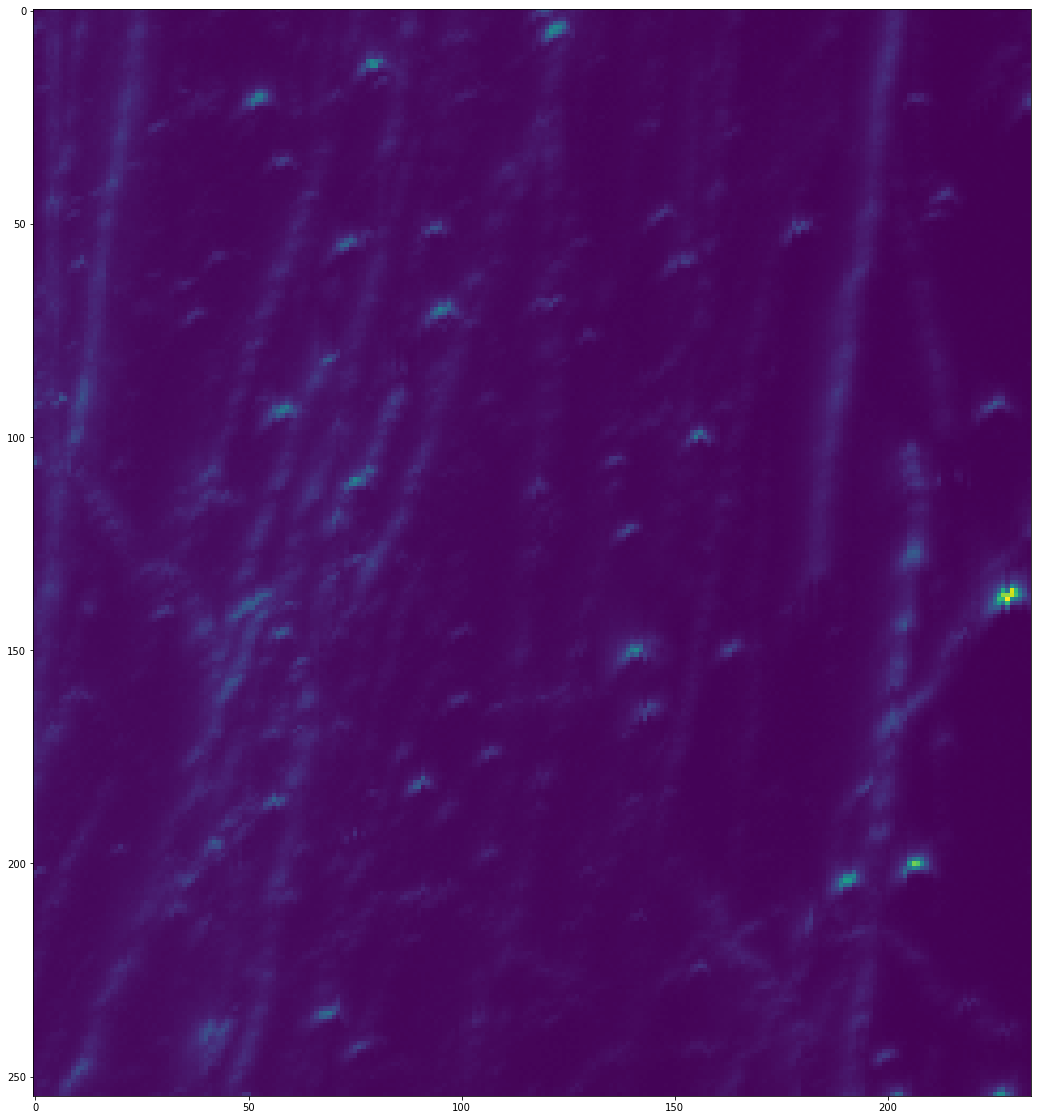

In [24]:
nodes = readSWC(177)
coords = getCoords(177)
xs,ys,zs = getCubeCoords(177)
cubes = findCubes(177)

current_cube = cubes[0]
im177 = np.float32(getCube(177, current_cube)/65535)

plt.figure(figsize=(20,20))
plt.imshow(im177.max(0))

In [25]:
current_cube

[8, 32, 4]

In [26]:
pred177 = segmentCube(im177, network)

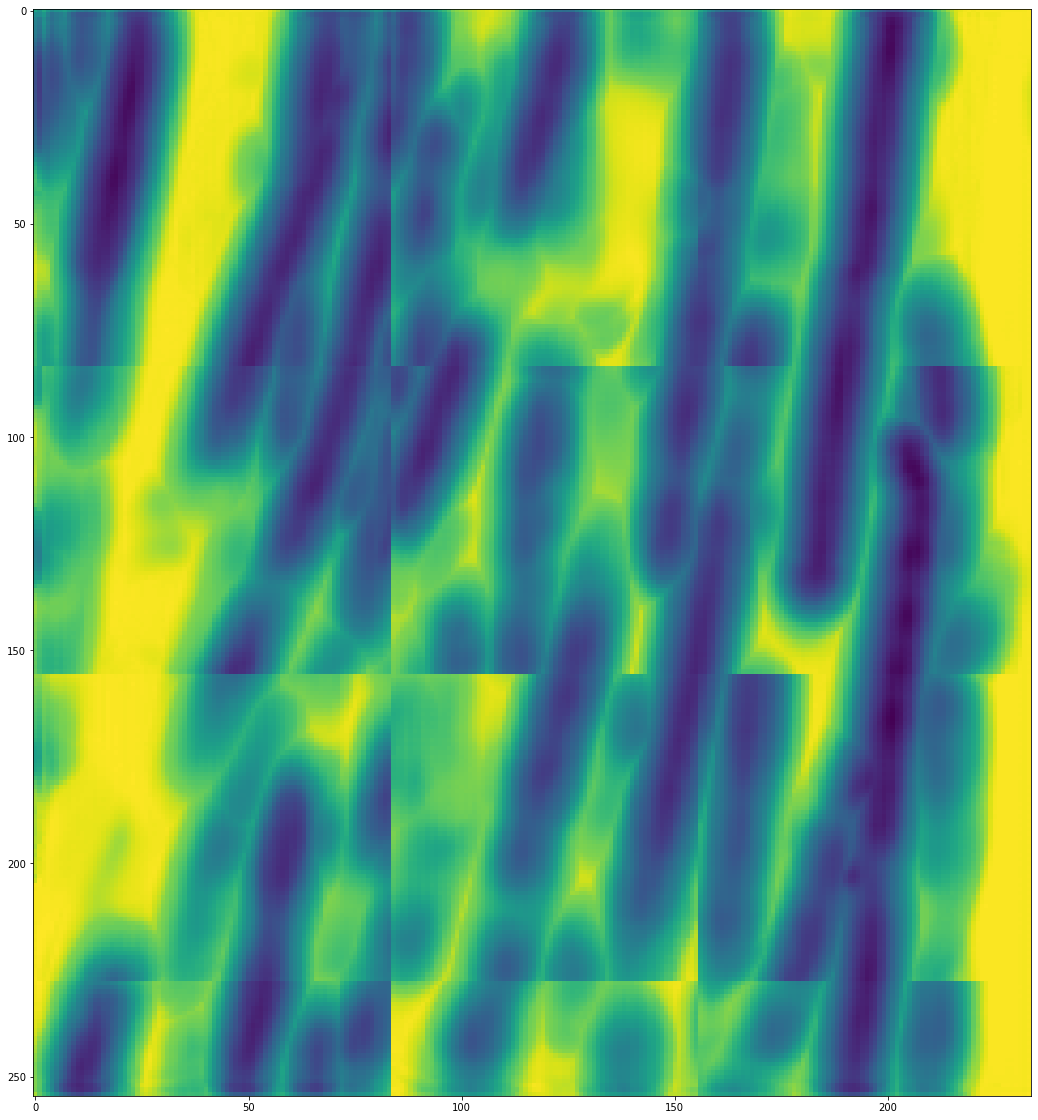

In [42]:
plt.figure(figsize=(20,20))
plt.imshow(pred177.min(0))

### Visualize pred

In [ ]:
np.save("./im177.npy", ims)
np.save("./pred177.npy", preds)

In [ ]:
ims = np.load("./im177.npy")
preds = np.load("./pred177.npy")

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(ims.max(0))

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(preds.min(0))